#Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from keras.callbacks import EarlyStopping
from tensorflow.keras import utils as np_utils

from transformers import BertForMaskedLM, BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
from transformers import AdamW
import torch.optim as optim
from tqdm import tqdm

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

import string
import math
import os
import glob

import nltk
nltk.download('punkt')


from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##MLFLOW Connection

In [ ]:
!pip3 install mlflow
import mlflow
import mlflow.pytorch

In [ ]:
!pip install pyngrok
from pyngrok import ngrok,conf
import subprocess
import getpass

In [ ]:
mlflow.set_tracking_uri("file:/content/drive/MyDrive/mlflow-runs")

In [ ]:
!ngrok authtoken 2epKCRxlJ3J0vmH2qLdC7LIGiia_QVT1k9URQQH71RdCQDFb

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
subprocess.Popen(['mlflow', 'ui', '--backend-store-uri', '/content/drive/My\ Drive/mlflow-runs'])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [ ]:
# Setup a tunnel to the UI
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://50be-34-67-145-48.ngrok-free.app


In [ ]:
!mlflow ui --backend-store-uri /content/drive/My\ Drive/mlflow-runs --port 5000

[2024-04-14 22:19:59 +0000] [23117] [INFO] Starting gunicorn 21.2.0
[2024-04-14 22:19:59 +0000] [23117] [INFO] Listening at: http://127.0.0.1:5000 (23117)
[2024-04-14 22:19:59 +0000] [23117] [INFO] Using worker: sync
[2024-04-14 22:19:59 +0000] [23118] [INFO] Booting worker with pid: 23118
[2024-04-14 22:19:59 +0000] [23119] [INFO] Booting worker with pid: 23119
[2024-04-14 22:19:59 +0000] [23120] [INFO] Booting worker with pid: 23120
[2024-04-14 22:19:59 +0000] [23121] [INFO] Booting worker with pid: 23121
[2024-04-14 22:20:39 +0000] [23117] [CRITICAL] WORKER TIMEOUT (pid:23119)
[2024-04-14 22:20:40 +0000] [23119] [INFO] Worker exiting (pid: 23119)
[2024-04-14 22:20:40 +0000] [23117] [ERROR] Worker (pid:23119) exited with code 1
[2024-04-14 22:20:40 +0000] [23117] [ERROR] Worker (pid:23119) exited with code 1.
[2024-04-14 22:20:40 +0000] [23309] [INFO] Booting worker with pid: 23309
[2024-04-14 22:20:45 +0000] [23117] [CRITICAL] WORKER TIMEOUT (pid:23118)
[2024-04-14 22:20:45 +0000] [

[2024-04-15 00:36:27 +0000] [23117] [INFO] Handling signal: int
[2024-04-15 00:36:27 +0000] [24894] [INFO] Worker exiting (pid: 24894)
[2024-04-15 00:36:27 +0000] [24802] [INFO] Worker exiting (pid: 24802)
[2024-04-15 00:36:27 +0000] [24826] [INFO] Worker exiting (pid: 24826)
[2024-04-15 00:36:27 +0000] [25026] [INFO] Worker exiting (pid: 25026)

Aborted!
[2024-04-15 00:36:28 +0000] [23117] [INFO] Shutting down: Master


#File Handling

In [5]:
# Read the text file dataset
with open("/content/drive/MyDrive/NLP_Project/ijcnlp_dailydialog/dialogues_text.txt", "r", encoding="utf-8") as file:
    conversations = file.readlines()
    # conversations = file.read().split('__eou__')

In [6]:
# Read the text file dataset
with open("/content/drive/MyDrive/NLP_Project/ijcnlp_dailydialog/dialogues_topic.txt", "r", encoding="utf-8") as file:
    topics = file.readlines()
    # conversations = file.read().split('__eou__')

##Subsetting to one topic - Relationship

In [7]:
len(topics), len(conversations)

(13118, 13118)

In [8]:
data = [1 for _ in topics]
s = pd.Series(data, index=topics)
s.groupby(level=0).count()

1\n     3646
10\n     485
2\n      487
3\n       55
4\n      667
5\n     4391
6\n     1065
7\n      267
8\n     1924
9\n      131
dtype: int64

In [9]:
conversations = np.array(conversations)[np.array(topics)=='5\n'].tolist()
len(conversations)

4391

#Preprocessing

In [10]:
# Preprocess the dataset
processed_conversations = [conv.strip().rsplit(' ',1)[0].rstrip(string.punctuation+' ').lower().replace(' ’ ','’').replace('__eou__','') for conv in conversations]
# processed_conversations = [conv.replace(string.punctuation,'') for conv in processed_conversations]
# processed_conversations[2]
# Define translation table to remove punctuation
remove_punctuation_table = str.maketrans('', '', string.punctuation.replace('\'',''))

# Remove punctuation from processed_conversations
processed_conversations_no_punct = [conv.translate(remove_punctuation_table) for conv in processed_conversations]

# Print processed_conversations without punctuation
# processed_conversations_no_punct[2]

processed_conversations_no_punct
processed_conversations_no_punct[2]

"what a wonderful party  i had a good time  how about you   i enjoyed myself  too   shall i give you a ride home   yes  if it's not too much of a trouble   it's no trouble at all because your house is on the way to my place   that's great  let's go"

In [11]:
def preprocess(len_sequence , processed_conversations_no_punct):
  conversations_1 = ' '
  for conv in processed_conversations_no_punct:
      conversations_1+= ' '+conv

  # processed_conversations = conversations.split()[:20000]
  conversations_2 = conversations_1.split()[:50000]
  print(len(conversations_2))

  length = len_sequence
  processed_conversations=[]

  for i in range(length, len(conversations_2)):
    sequence = conversations_2[i-length:i]
    lines = ' '.join(sequence)
    processed_conversations.append(lines)

  return processed_conversations


In [12]:
processed_conversations = preprocess(5, processed_conversations_no_punct)

50000


In [13]:
processed_conversations = preprocess(5, processed_conversations)
processed_conversations

['bob what are you thinking',
 'what are you thinking about',
 "are you thinking about i'm",
 "you thinking about i'm looking",
 "thinking about i'm looking forward",
 "about i'm looking forward to",
 "i'm looking forward to going",
 'looking forward to going to',
 'forward to going to america',
 'to going to america when',
 'going to america when do',
 'to america when do you',
 'america when do you go',
 'when do you go next',
 'do you go next week',
 'you go next week what',
 'go next week what do',
 'next week what do you',
 'week what do you say',
 'what do you say to',
 'do you say to eating',
 'you say to eating out',
 'say to eating out maggie',
 'to eating out maggie yeah',
 'eating out maggie yeah why',
 'out maggie yeah why not',
 'maggie yeah why not we',
 "yeah why not we haven't",
 "why not we haven't been",
 "not we haven't been out",
 "we haven't been out for",
 "haven't been out for dinner",
 'been out for dinner for',
 'out for dinner for quite',
 'for dinner for quit

#Functions - Evaluation model

In [ ]:
def evaluate_model(model, X_test, y_test, k=5):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Calculate perplexity
    perplexity = np.exp(test_loss)

    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate top-k accuracy
    # Get indices of top-k predicted classes for each example
    top_k_indices = np.argsort(y_pred_probs, axis=1)[:, -k:]

    # Check if true class is among the top-k predicted classes for each example
    true_class_indices = np.argmax(y_test, axis=1)
    in_top_k = np.any(top_k_indices == true_class_indices[:, np.newaxis], axis=1)

    # Calculate top-k accuracy
    top_k_accuracy = np.mean(in_top_k)


    # return test_loss, test_accuracy, perplexity, top_k_accuracy
    return test_loss, test_accuracy, perplexity, top_k_accuracy



    return top_k_accuracy


#LSTM

## Learning embedding from scratch

In [ ]:
def LSTM_model( num_layers = 1, units = 100, embedding_dim = 300, optimizer = 'adam', batch_size = 32, epochs = 30):


  print(num_layers, units, embedding_dim, '/n')

  #Logging all parameters
  mlflow.log_param('batch_size',batch_size)
  mlflow.log_param('layers',num_layers)
  mlflow.log_param('units',units)
  mlflow.log_param('embedding_dim',embedding_dim)
  mlflow.log_param('epochs',epochs)
  mlflow.log_param('optimizer',optimizer)
  # mlflow.log_param('length',length)

  # processed_conversations = preprocess(length, conversations)

  # Data Preprocessing
  tokenizer = Tokenizer(oov_token='<oov>')
  tokenizer.fit_on_texts(processed_conversations)
  vocab_size = len(tokenizer.word_index) + 1

  sequences = tokenizer.texts_to_sequences(processed_conversations)
  max_sequence_len = max([len(seq) for seq in sequences])
  padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

  X = padded_sequences[:, :-1]
  y = padded_sequences[:, -1]

  # Convert target data to one-hot encoding
  y = np_utils.to_categorical(y, num_classes=vocab_size)

  # Splitting the data into train, validation, and test sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

  print("Training set shape:", X_train.shape, y_train.shape)
  print("Validation set shape:", X_val.shape, y_val.shape)
  print("Test set shape:", X_test.shape, y_test.shape)



  if num_layers == 1:
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_len - 1),
    tf.keras.layers.LSTM(units),
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.Dense(vocab_size, activation='softmax')])

  else:
    model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_len - 1),
            tf.keras.layers.LSTM(units, return_sequences=True),
        ])
    for i in range(num_layers-2):
      model.add(tf.keras.layers.LSTM(units, return_sequences=True))
    model.add(tf.keras.layers.LSTM(units))
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Define early stopping to prevent overfitting
  early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

  # Train the model
  with tf.device('/GPU:0'):  # Specify GPU device
    history = model.fit(X_train, y_train, batch_size= batch_size , epochs=epochs, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

  # Log train and validation loss and accuracy for each epoch
  for epoch in range(len(history.history['loss'])):
      mlflow.log_metric("train_loss", history.history['loss'][epoch], epoch)
      mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], epoch)
      mlflow.log_metric("val_loss", history.history['val_loss'][epoch], epoch)
      mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], epoch)



  # Plot epoch vs train accuracy and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Epoch vs Train/Validation Accuracy')
  plt.legend()
  plt.grid(True)

  # Plot epoch vs train loss and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Epoch vs Train/Validation Loss')
  plt.legend()
  plt.grid(True)

  # Adjust layout and save the plot as an image file
  plt.tight_layout()
  plt.savefig("epoch_vs_metrics.png")

  # Log the plot to MLflow
  mlflow.log_artifact("epoch_vs_metrics.png")

  # Evaluate the model on the test set
  test_loss, test_accuracy, perplexity, top_k_accuracy = evaluate_model(model, X_test, y_test)


  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)
  print("Perplexity:", perplexity)
  print("Top-5 Accuracy:", top_k_accuracy)

  # Log test metrics
  mlflow.log_metric("test_loss", test_loss)
  mlflow.log_metric("test_accuracy", test_accuracy)
  mlflow.log_metric("perplexity", perplexity)
  mlflow.log_metric("top_5_accuracy", top_k_accuracy)


In [ ]:
# mlflow.create_experiment('LSTM_fullconv_scratchemb_early')

mlflow.set_experiment('LSTM_fullconv_scratchemb_early')

for epoch in [30]:
  for batch_size in [32, 128]:
    for optimizer in ['adam']:
      for embedding_dim in [300, 500]:
        for num_layers in [1,8]:
          for units in [100,200]:
            # Start MLflow run
            with mlflow.start_run():
              # expt_id = '%d%d%d%d'% (int(num_layers),int(units),int(embedding_dim),int(batch_size))
              LSTM_model(num_layers = num_layers, units = units, embedding_dim = embedding_dim, batch_size = batch_size, epochs = epoch, optimizer = optimizer)



In [ ]:
mlflow.end_run()

1 100 10 /n
Training set shape: (39996, 4) (39996, 1722)
Validation set shape: (4999, 4) (4999, 1722)
Test set shape: (5000, 4) (5000, 1722)
Epoch 1/30
1250/1250 [==============================] - 18s 11ms/step - loss: 5.8024 - accuracy: 0.0433 - val_loss: 5.5787 - val_accuracy: 0.0404
Epoch 2/30
1250/1250 [==============================] - 10s 8ms/step - loss: 5.3605 - accuracy: 0.0597 - val_loss: 5.1939 - val_accuracy: 0.1122
Epoch 3/30
1250/1250 [==============================] - 11s 9ms/step - loss: 4.7970 - accuracy: 0.1812 - val_loss: 4.5214 - val_accuracy: 0.2737
Epoch 4/30
1250/1250 [==============================] - 9s 8ms/step - loss: 4.1534 - accuracy: 0.3162 - val_loss: 4.1102 - val_accuracy: 0.3657
Epoch 5/30
1250/1250 [==============================] - 11s 9ms/step - loss: 3.7311 - accuracy: 0.3923 - val_loss: 3.9012 - val_accuracy: 0.4213
Epoch 6/30
1250/1250 [==============================] - 9s 7ms/step - loss: 3.4262 - accuracy: 0.4386 - val_loss: 3.7265 - val_accurac

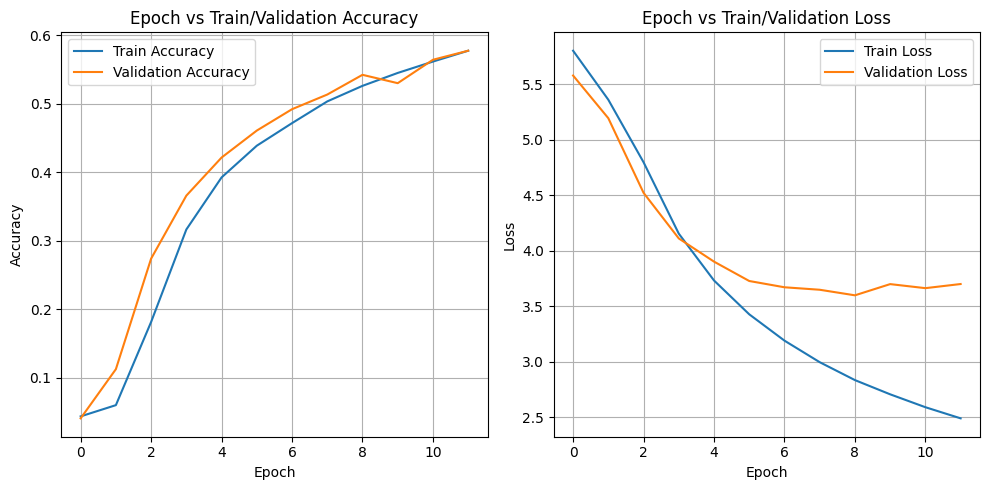

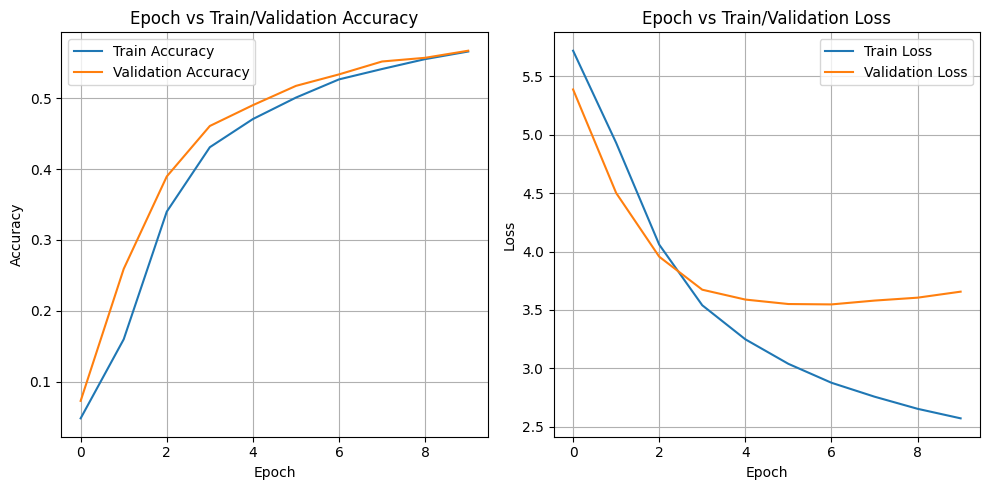

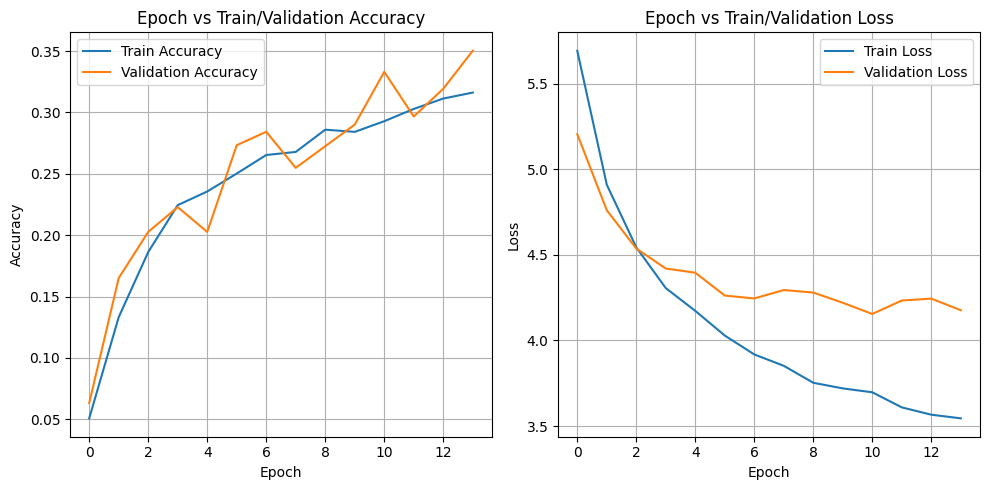

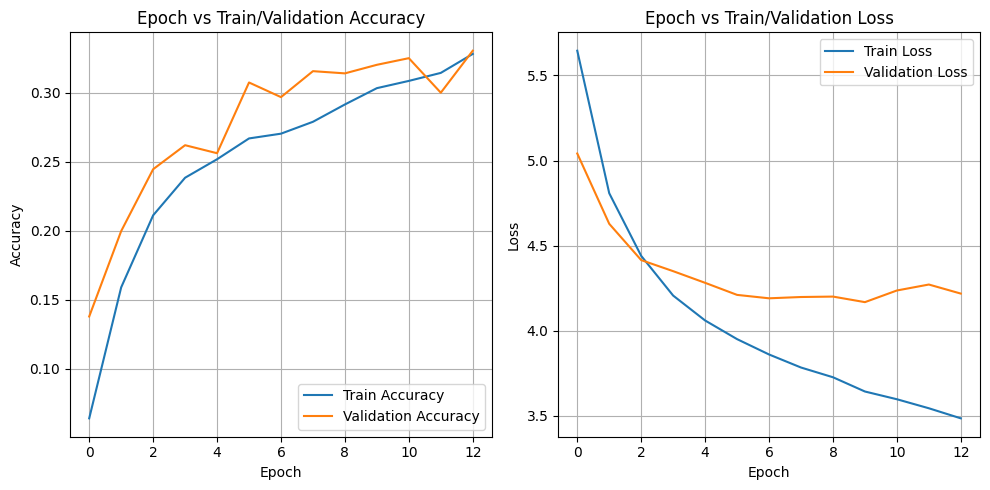

In [ ]:
# mlflow.create_experiment('Rel_embscratch_withrelu')

mlflow.set_experiment('Rel_embscratch_withrelu')

for batch_size in [32]:
  for num_layers in [1,8]:
    for embedding_dim in [10]:
      for units in [100,200]:
        with mlflow.start_run():
          LSTM_model(num_layers = num_layers,
                     units = units,
                      embedding_dim = embedding_dim,
                     batch_size = batch_size)



In [ ]:
#Without Relu
def LSTM_model( num_layers = 1, units = 100, embedding_dim = 300, optimizer = 'adam', batch_size = 32, epochs = 30):


  print(num_layers, units, embedding_dim, '/n')

  #Logging all parameters
  mlflow.log_param('batch_size',batch_size)
  mlflow.log_param('layers',num_layers)
  mlflow.log_param('units',units)
  mlflow.log_param('embedding_dim',embedding_dim)
  mlflow.log_param('epochs',epochs)
  mlflow.log_param('optimizer',optimizer)
  # mlflow.log_param('length',length)

  # processed_conversations = preprocess(length, conversations)

  # Data Preprocessing
  tokenizer = Tokenizer(oov_token='<oov>')
  tokenizer.fit_on_texts(processed_conversations)
  vocab_size = len(tokenizer.word_index) + 1

  sequences = tokenizer.texts_to_sequences(processed_conversations)
  max_sequence_len = max([len(seq) for seq in sequences])
  padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

  X = padded_sequences[:, :-1]
  y = padded_sequences[:, -1]

  # Convert target data to one-hot encoding
  y = np_utils.to_categorical(y, num_classes=vocab_size)

  # Splitting the data into train, validation, and test sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

  print("Training set shape:", X_train.shape, y_train.shape)
  print("Validation set shape:", X_val.shape, y_val.shape)
  print("Test set shape:", X_test.shape, y_test.shape)



  if num_layers == 1:
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_len - 1),
    tf.keras.layers.LSTM(units),
    tf.keras.layers.Dense(vocab_size, activation='softmax')])

  else:
    model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_sequence_len - 1),
            tf.keras.layers.LSTM(units, return_sequences=True),
        ])
    for i in range(num_layers-2):
      model.add(tf.keras.layers.LSTM(units, return_sequences=True))
    model.add(tf.keras.layers.LSTM(units))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Define early stopping to prevent overfitting
  early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

  # Train the model
  with tf.device('/GPU:0'):  # Specify GPU device
    history = model.fit(X_train, y_train, batch_size= batch_size , epochs=epochs, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

  # Log train and validation loss and accuracy for each epoch
  for epoch in range(len(history.history['loss'])):
      mlflow.log_metric("train_loss", history.history['loss'][epoch], epoch)
      mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], epoch)
      mlflow.log_metric("val_loss", history.history['val_loss'][epoch], epoch)
      mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], epoch)



  # Plot epoch vs train accuracy and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Epoch vs Train/Validation Accuracy')
  plt.legend()
  plt.grid(True)

  # Plot epoch vs train loss and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Epoch vs Train/Validation Loss')
  plt.legend()
  plt.grid(True)

  # Adjust layout and save the plot as an image file
  plt.tight_layout()
  plt.savefig("epoch_vs_metrics.png")

  # Log the plot to MLflow
  mlflow.log_artifact("epoch_vs_metrics.png")

  # Evaluate the model on the test set
  test_loss, test_accuracy, perplexity, top_k_accuracy = evaluate_model(model, X_test, y_test)


  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)
  print("Perplexity:", perplexity)
  print("Top-5 Accuracy:", top_k_accuracy)

  # Log test metrics
  mlflow.log_metric("test_loss", test_loss)
  mlflow.log_metric("test_accuracy", test_accuracy)
  mlflow.log_metric("perplexity", perplexity)
  mlflow.log_metric("top_5_accuracy", top_k_accuracy)


5 100 10 /n
Training set shape: (39996, 4) (39996, 1722)
Validation set shape: (4999, 4) (4999, 1722)
Test set shape: (5000, 4) (5000, 1722)
Epoch 1/30
1250/1250 [==============================] - 33s 20ms/step - loss: 5.5883 - accuracy: 0.0616 - val_loss: 5.0406 - val_accuracy: 0.1050
Epoch 2/30
1250/1250 [==============================] - 19s 15ms/step - loss: 4.7577 - accuracy: 0.1283 - val_loss: 4.6626 - val_accuracy: 0.1246
Epoch 3/30
1250/1250 [==============================] - 21s 17ms/step - loss: 4.4613 - accuracy: 0.1469 - val_loss: 4.4753 - val_accuracy: 0.1620
Epoch 4/30
1250/1250 [==============================] - 19s 15ms/step - loss: 4.2630 - accuracy: 0.1740 - val_loss: 4.4284 - val_accuracy: 0.1666
Epoch 5/30
1250/1250 [==============================] - 19s 15ms/step - loss: 4.1242 - accuracy: 0.1948 - val_loss: 4.2702 - val_accuracy: 0.2344
Epoch 6/30
1250/1250 [==============================] - 18s 15ms/step - loss: 4.0034 - accuracy: 0.2209 - val_loss: 4.2160 - val_

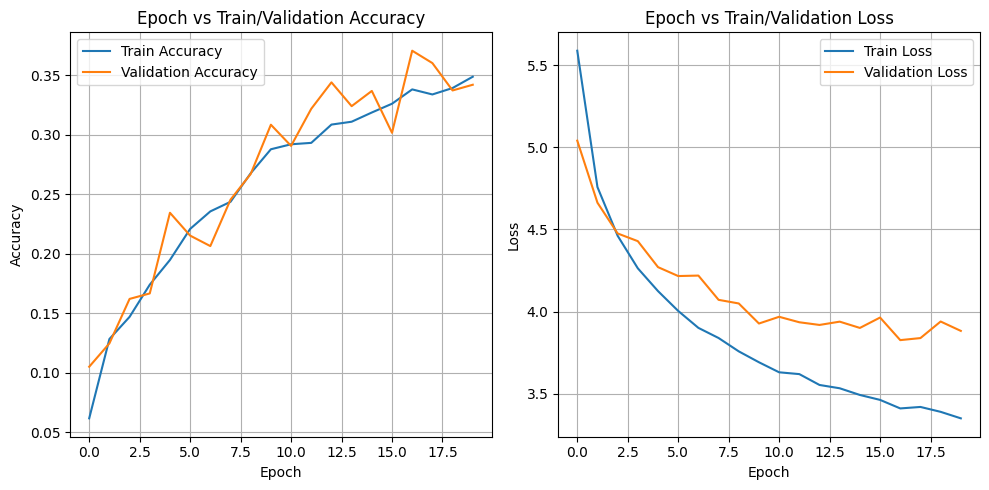

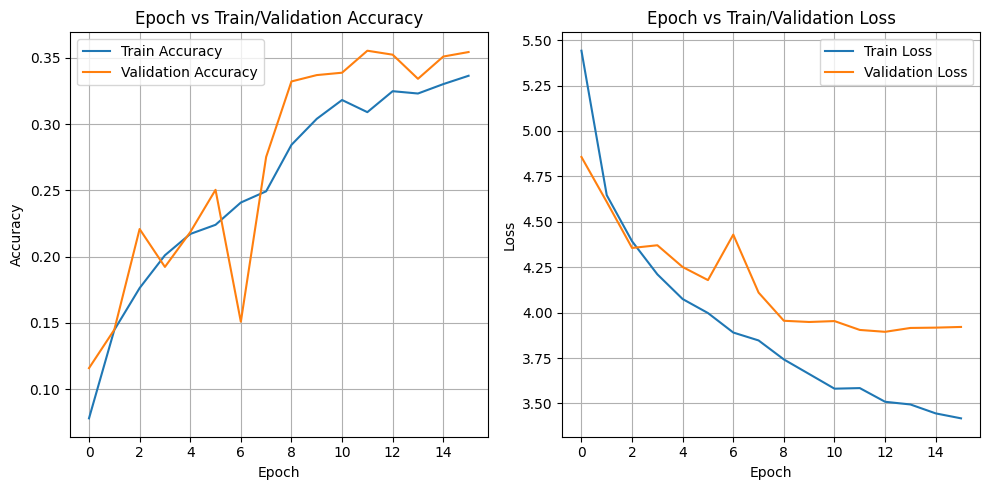

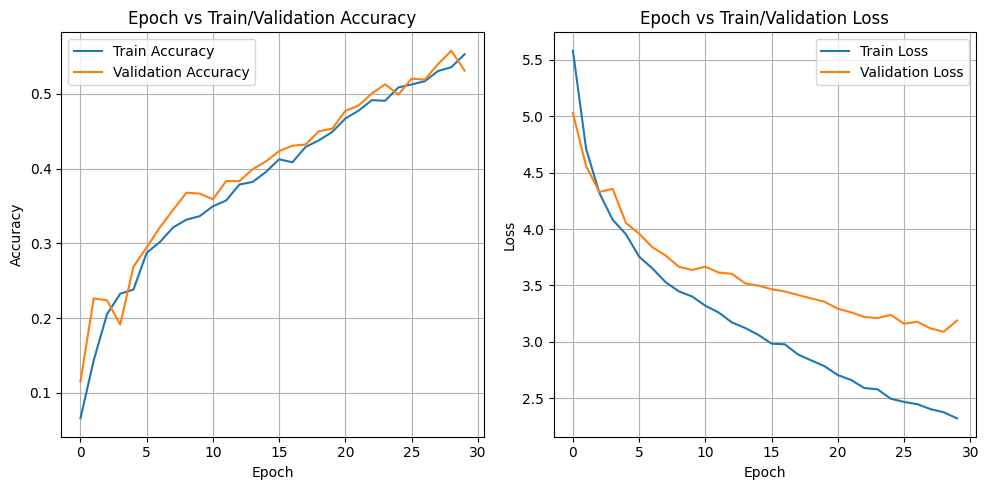

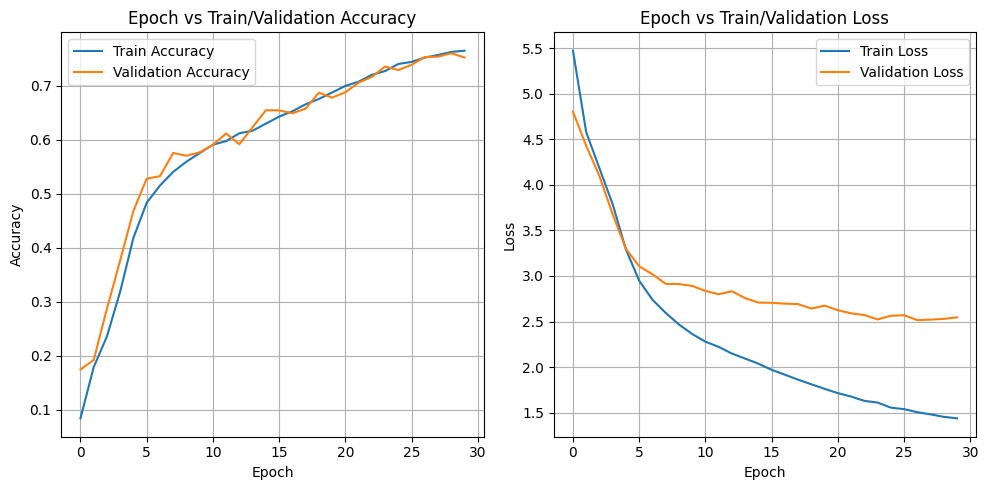

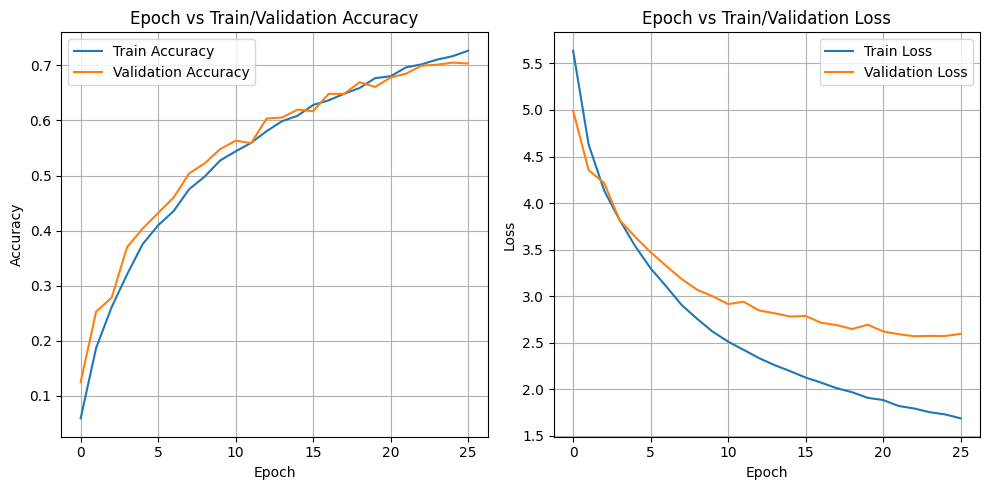

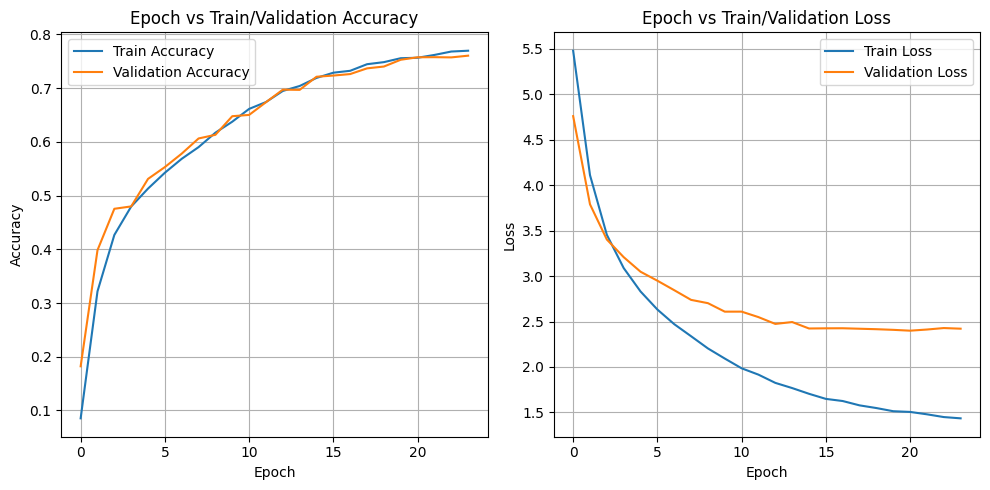

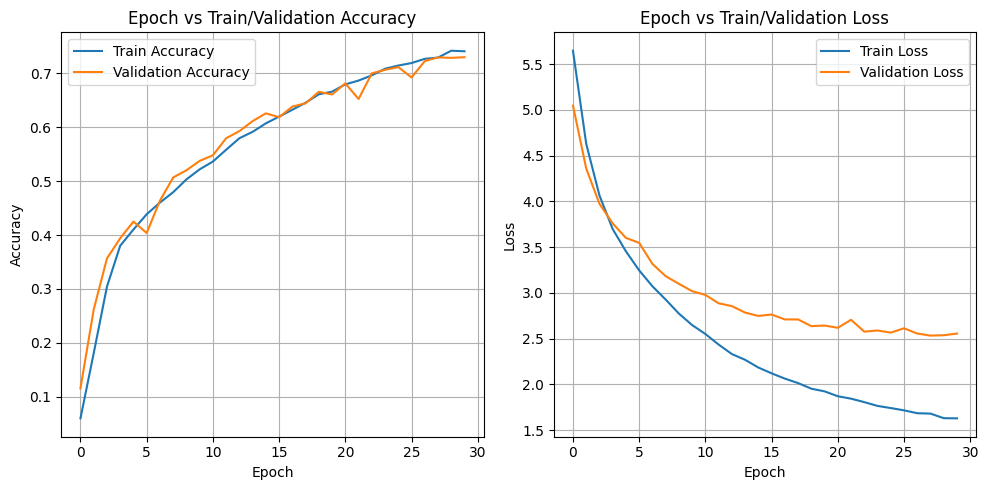

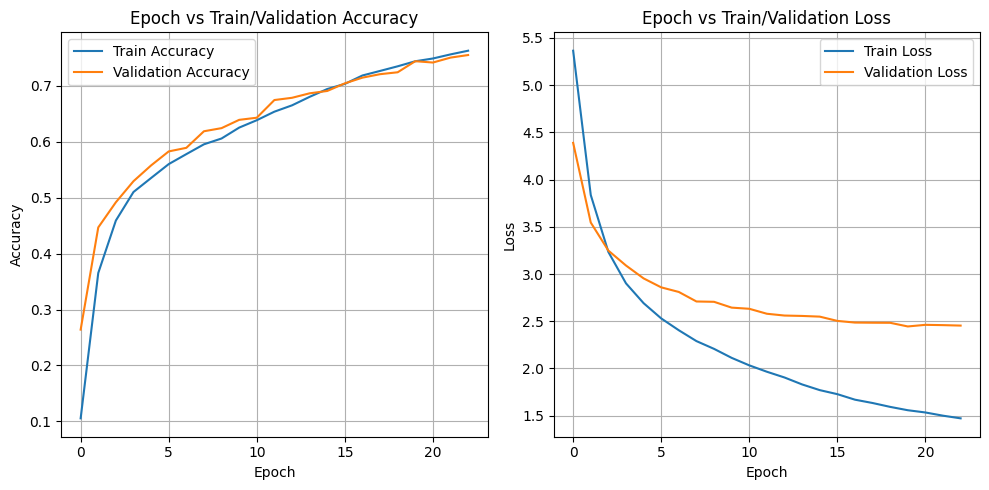

In [ ]:
# mlflow.create_experiment('Rel_embscratch_withoutrelu')

mlflow.set_experiment('Rel_embscratch_withoutrelu')

for batch_size in [32]:
  for num_layers in [5]:
    for embedding_dim in [10, 100, 300, 500]:
      for units in [100, 200]:
        with mlflow.start_run():
          LSTM_model(num_layers = num_layers,
                     units = units,
                      embedding_dim = embedding_dim,
                     batch_size = batch_size)



1 100 500 /n
Training set shape: (39996, 4) (39996, 1722)
Validation set shape: (4999, 4) (4999, 1722)
Test set shape: (5000, 4) (5000, 1722)
Epoch 1/15
1250/1250 [==============================] - 19s 13ms/step - loss: 5.2155 - accuracy: 0.1689 - val_loss: 4.2842 - val_accuracy: 0.3285
Epoch 2/15
1250/1250 [==============================] - 8s 7ms/step - loss: 3.7014 - accuracy: 0.4413 - val_loss: 3.4421 - val_accuracy: 0.5337
Epoch 3/15
1250/1250 [==============================] - 11s 9ms/step - loss: 2.9045 - accuracy: 0.5880 - val_loss: 3.0530 - val_accuracy: 0.6259
Epoch 4/15
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4071 - accuracy: 0.6590 - val_loss: 2.8811 - val_accuracy: 0.6795
Epoch 5/15
1250/1250 [==============================] - 11s 9ms/step - loss: 2.0439 - accuracy: 0.7034 - val_loss: 2.7869 - val_accuracy: 0.7081
Epoch 6/15
1250/1250 [==============================] - 8s 6ms/step - loss: 1.7616 - accuracy: 0.7372 - val_loss: 2.7570 - val_accurac

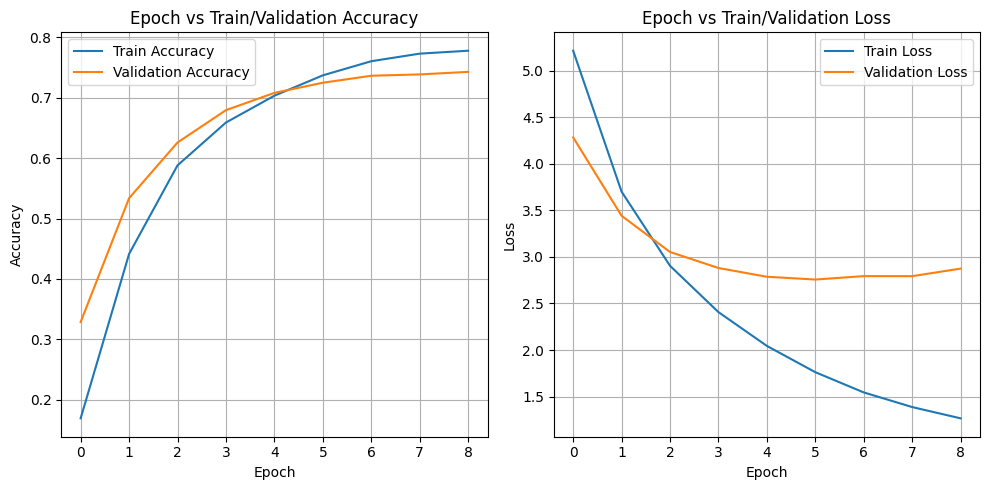

In [ ]:
# mlflow.create_experiment('check_rel_1')

mlflow.set_experiment('check_rel_1')
LSTM_model(num_layers = 1, units = 100, embedding_dim = 500, optimizer = 'adam', batch_size = 32, epochs = 15)

1 100 500 /n
Training set shape: (15996, 4) (15996, 946)
Validation set shape: (1999, 4) (1999, 946)
Test set shape: (2000, 4) (2000, 946)
Epoch 1/15
500/500 [==============================] - 10s 13ms/step - loss: 5.4501 - accuracy: 0.1045 - val_loss: 4.8372 - val_accuracy: 0.1831
Epoch 2/15
500/500 [==============================] - 3s 6ms/step - loss: 4.0608 - accuracy: 0.3343 - val_loss: 3.8927 - val_accuracy: 0.4257
Epoch 3/15
500/500 [==============================] - 4s 8ms/step - loss: 3.1262 - accuracy: 0.5190 - val_loss: 3.4394 - val_accuracy: 0.5393
Epoch 4/15
500/500 [==============================] - 5s 10ms/step - loss: 2.5318 - accuracy: 0.6138 - val_loss: 3.1155 - val_accuracy: 0.6168
Epoch 5/15
500/500 [==============================] - 4s 7ms/step - loss: 2.0714 - accuracy: 0.6770 - val_loss: 2.9598 - val_accuracy: 0.6693
Epoch 6/15
500/500 [==============================] - 3s 6ms/step - loss: 1.7246 - accuracy: 0.7327 - val_loss: 2.8779 - val_accuracy: 0.6948
Epoch 

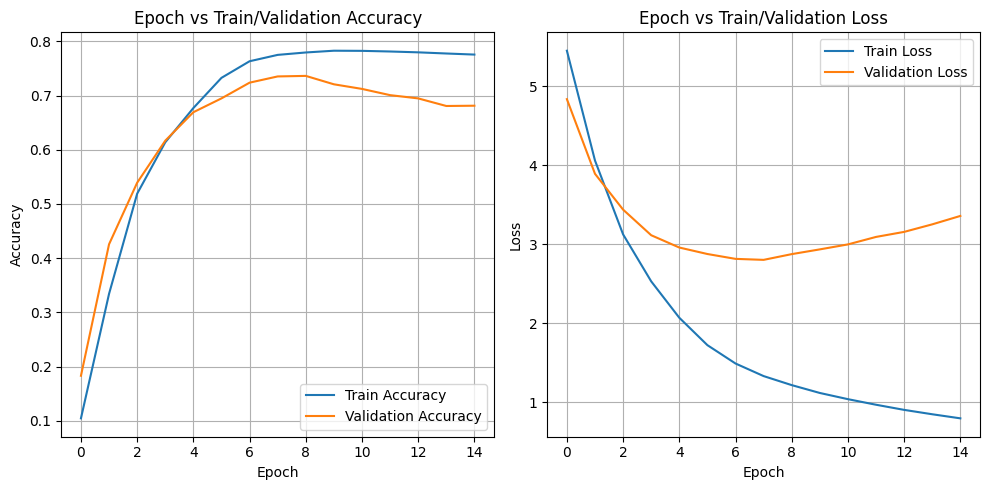

In [ ]:
# mlflow.create_experiment('check_rel_1')

mlflow.set_experiment('check_rel_1')
LSTM_model(num_layers = 1, units = 100, embedding_dim = 500, optimizer = 'adam', batch_size = 32, epochs = 15)

In [ ]:
# mlflow.create_experiment('LSTM_fullconv_scratchemb_early')

mlflow.set_experiment('LSTM_fullconv_scratchemb_early')

for epoch in [30]:
  for batch_size in [32]:
    for optimizer in ['adam']:
      for embedding_dim in [300]:
        for num_layers in [1]:
          for units in [100]:
            # Start MLflow run
            with mlflow.start_run():
              # expt_id = '%d%d%d%d'% (int(num_layers),int(units),int(embedding_dim),int(batch_size))
              LSTM(num_layers = num_layers, units = units, embedding_dim = embedding_dim, batch_size = batch_size, epochs = epoch, optimizer = optimizer)




##Word2Vec Embeddings

In [ ]:
# Data Preprocessing
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(processed_conversations)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(processed_conversations)


max_sequence_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]

# Convert target data to one-hot encoding
y = np_utils.to_categorical(y, num_classes=vocab_size)


# Splitting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (39996, 4) (39996, 1722)
Validation set shape: (4999, 4) (4999, 1722)
Test set shape: (5000, 4) (5000, 1722)


In [ ]:
def LSTM_with_Word2Vec(num_layers = 1, units = 100, embedding_dim = 10, optimizer = 'adam', batch_size = 32, epochs = 30, window=5, sg=1):

  # Convert each conversation string into a list of words
  tokenized_conversations = [conversation.split() for conversation in processed_conversations]
  # Train Word2Vec model
  word2vec_model = Word2Vec(sentences=tokenized_conversations, vector_size=embedding_dim, window=window, min_count=1, sg=sg)


  # #Logging all parameters
  mlflow.log_param('batch_size',batch_size)
  mlflow.log_param('layers',num_layers)
  mlflow.log_param('units',units)
  mlflow.log_param('embedding_dim',embedding_dim)
  mlflow.log_param('epochs',epochs)
  mlflow.log_param('optimizer',optimizer)
  mlflow.log_param('window',window)
  mlflow.log_param('sg',sg)

  # Prepare embedding matrix
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
      if word in word2vec_model.wv:
          embedding_matrix[i] = word2vec_model.wv[word]

  if num_layers == 1:
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],input_length=max_sequence_len - 1 , trainable=False),
    tf.keras.layers.LSTM(units),
    tf.keras.layers.Dense(vocab_size, activation='softmax')])

  else:
    model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_len - 1, trainable=False),
            tf.keras.layers.LSTM(units, return_sequences=True),
        ])
    for i in range(num_layers-2):
      model.add(tf.keras.layers.LSTM(units, return_sequences=True))
    model.add(tf.keras.layers.LSTM(units))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Define early stopping to prevent overfitting
  early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

  # Train the model
  with tf.device('/GPU:0'):  # Specify GPU device
    history = model.fit(X_train, y_train, batch_size= batch_size , epochs=epochs, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

  # Log train and validation loss and accuracy for each epoch
  for epoch in range(len(history.history['loss'])):
      mlflow.log_metric("train_loss", history.history['loss'][epoch], epoch)
      mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], epoch)
      mlflow.log_metric("val_loss", history.history['val_loss'][epoch], epoch)
      mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], epoch)



  # Plot epoch vs train accuracy and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Epoch vs Train/Validation Accuracy')
  plt.legend()
  plt.grid(True)

  # Plot epoch vs train loss and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Epoch vs Train/Validation Loss')
  plt.legend()
  plt.grid(True)

  # Adjust layout and save the plot as an image file
  plt.tight_layout()
  plt.savefig("epoch_vs_metrics.png")

  # Log the plot to MLflow
  mlflow.log_artifact("epoch_vs_metrics.png")

  # Evaluate the model on the test set
  test_loss, test_accuracy, perplexity, top_k_accuracy= evaluate_model(model, X_test, y_test)


  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)
  print("Perplexity:", perplexity)
  print("Top-5 Accuracy:", top_k_accuracy)

  # # Log test metrics
  mlflow.log_metric("test_loss", test_loss)
  mlflow.log_metric("test_accuracy", test_accuracy)
  mlflow.log_metric("perplexity", perplexity)
  mlflow.log_metric("top_5_accuracy", top_k_accuracy)


In [ ]:
mlflow.end_run()

Epoch 1/30
1250/1250 [==============================] - 29s 15ms/step - loss: 5.5511 - accuracy: 0.0637 - val_loss: 4.9204 - val_accuracy: 0.0956
Epoch 2/30
1250/1250 [==============================] - 17s 14ms/step - loss: 4.6441 - accuracy: 0.1159 - val_loss: 4.5036 - val_accuracy: 0.1302
Epoch 3/30
1250/1250 [==============================] - 18s 15ms/step - loss: 4.2976 - accuracy: 0.1554 - val_loss: 4.3666 - val_accuracy: 0.1660
Epoch 4/30
1250/1250 [==============================] - 18s 15ms/step - loss: 4.0786 - accuracy: 0.1982 - val_loss: 4.0526 - val_accuracy: 0.2490
Epoch 5/30
1250/1250 [==============================] - 18s 14ms/step - loss: 3.9049 - accuracy: 0.2302 - val_loss: 3.9678 - val_accuracy: 0.2444
Epoch 6/30
1250/1250 [==============================] - 18s 14ms/step - loss: 3.7912 - accuracy: 0.2454 - val_loss: 3.9393 - val_accuracy: 0.2474
Epoch 7/30
1250/1250 [==============================] - 18s 14ms/step - loss: 3.6841 - accuracy: 0.2718 - val_loss: 3.8274 -

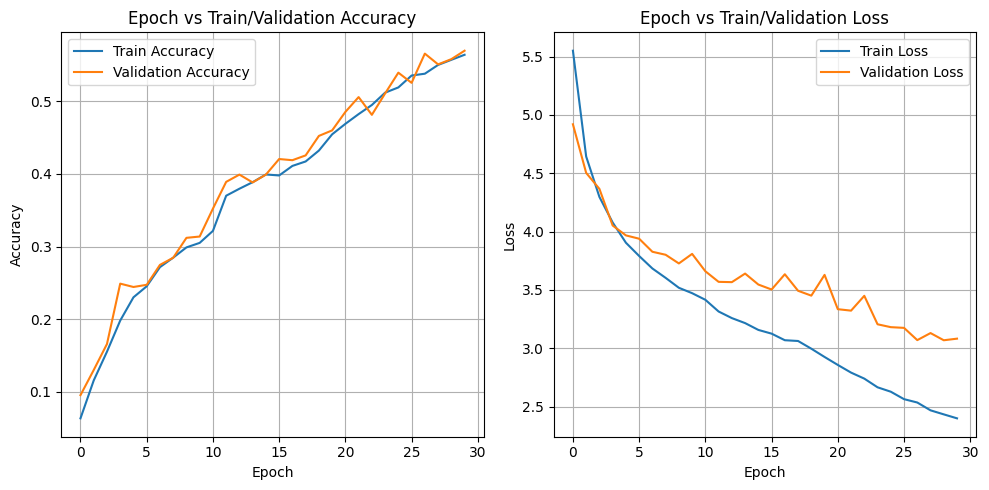

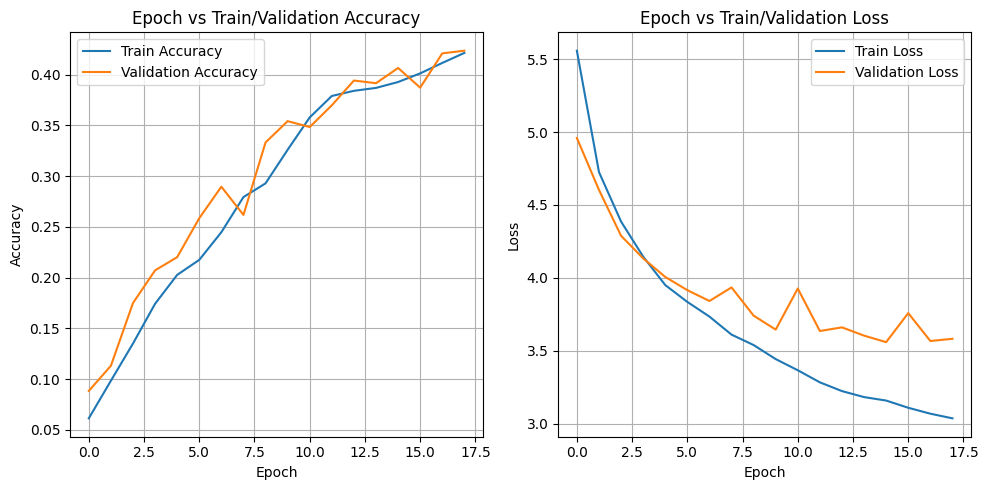

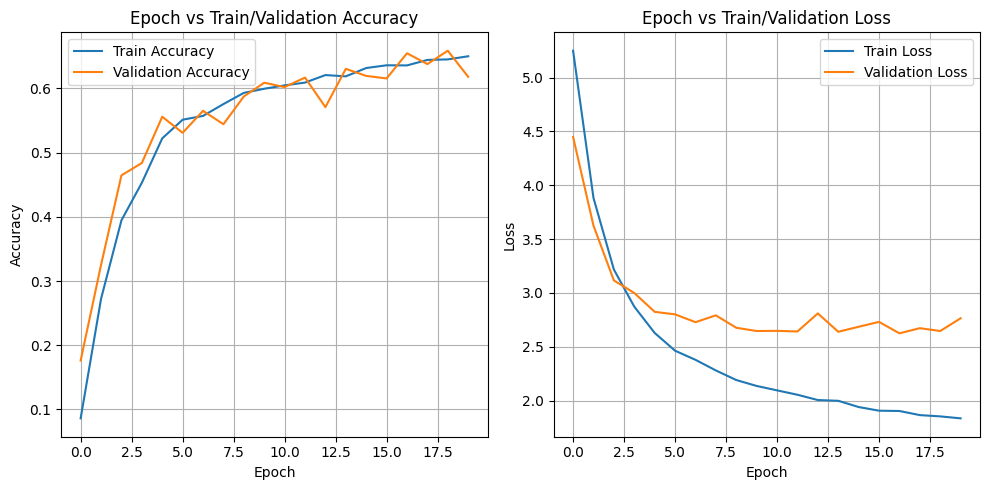

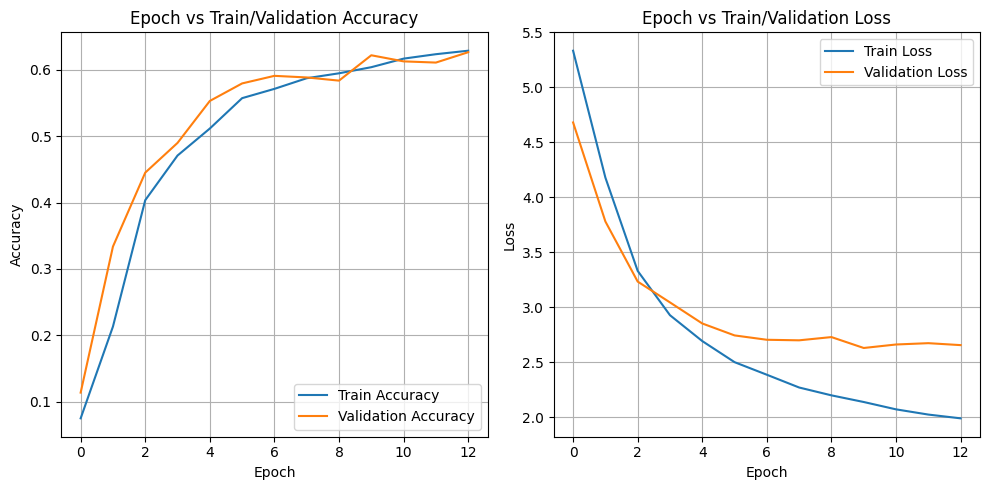

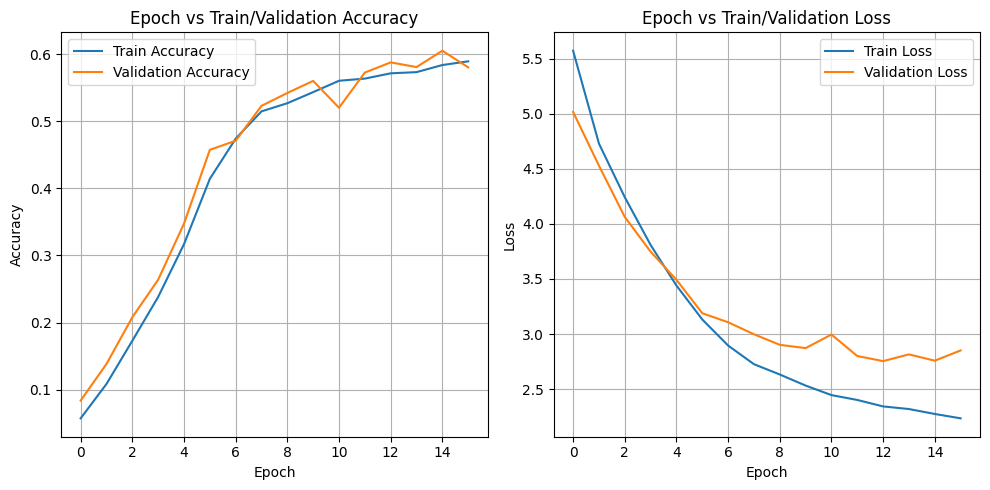

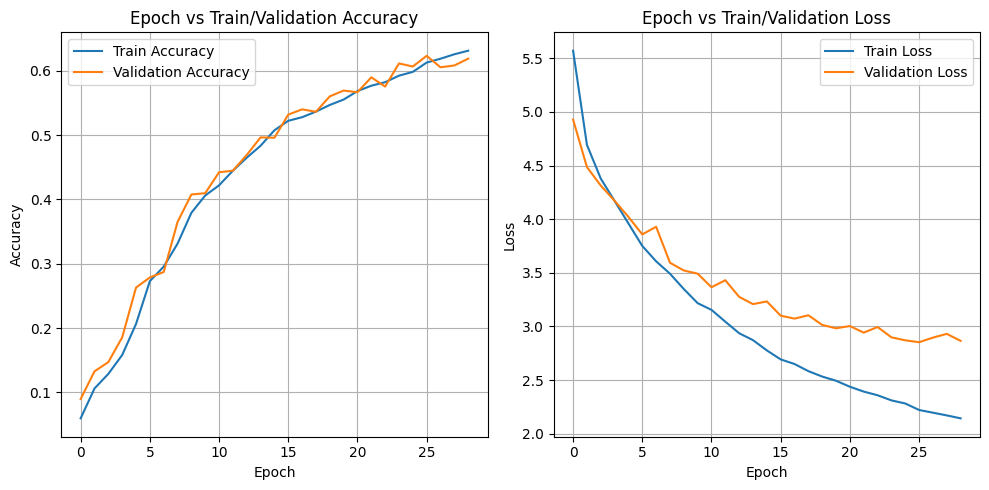

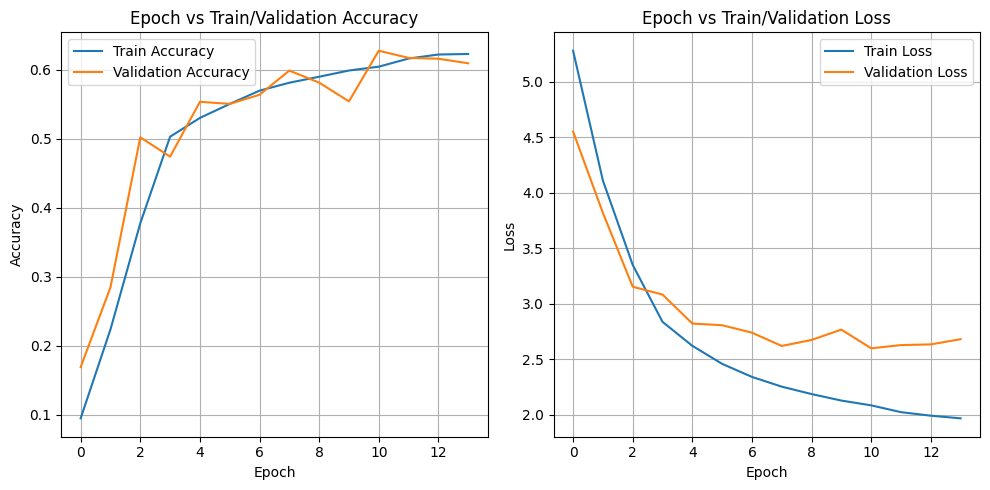

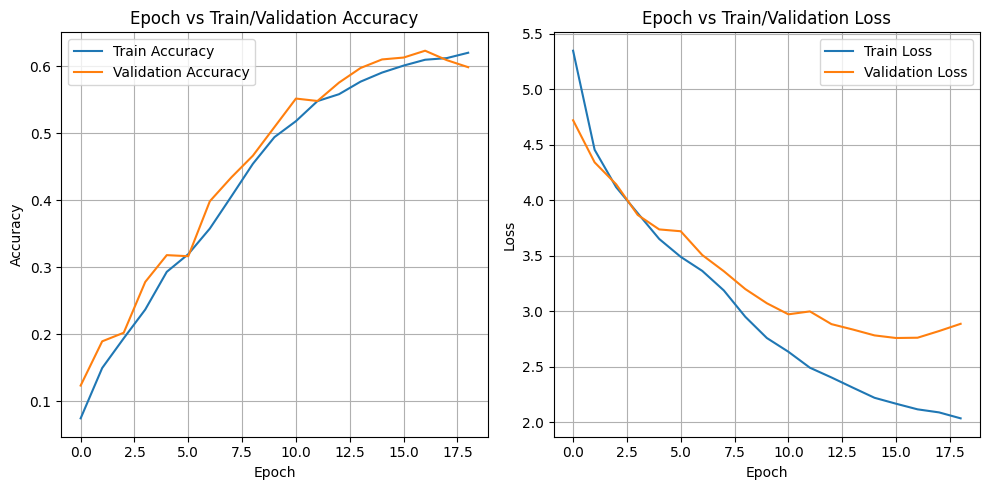

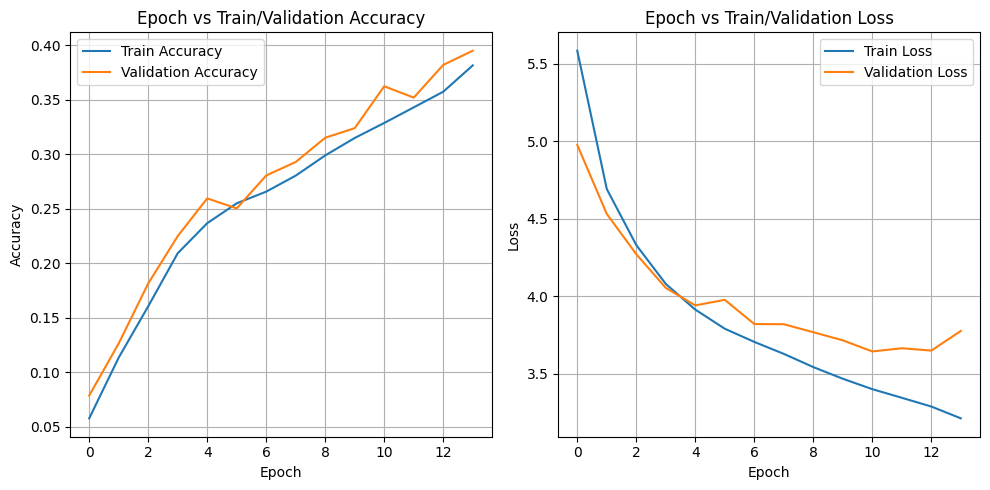

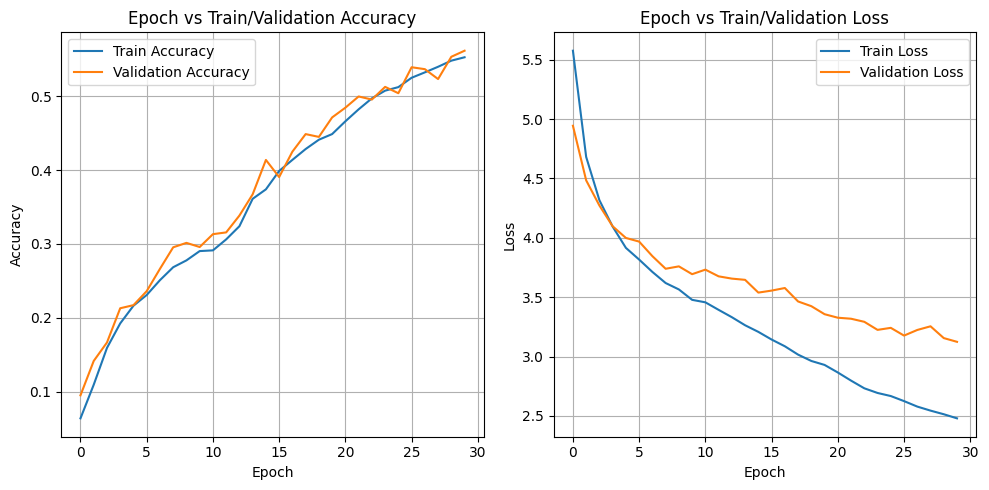

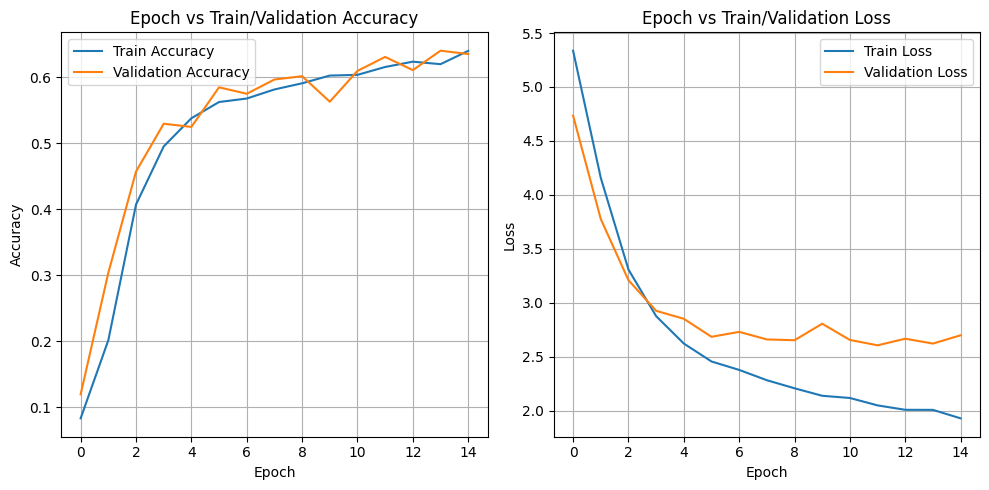

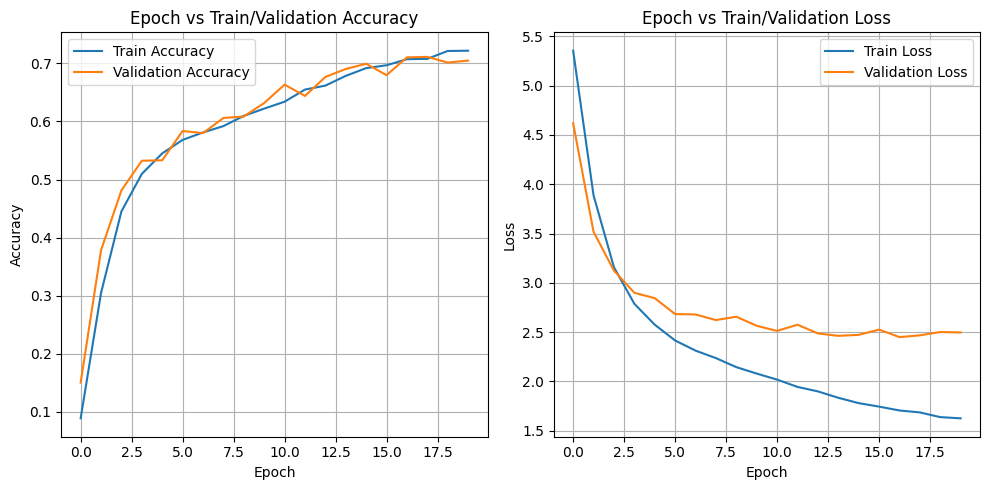

In [ ]:
# mlflow.create_experiment('Rel_word2vec_withoutrelu')
mlflow.set_experiment('Rel_word2vec_withoutrelu')


for embedding_dim in [100, 300, 500]:
  for num_layers in [5]:
    for units in [100, 200]:
      for window in [2]:
        for sg in [1,0]:
          with mlflow.start_run():
            LSTM_with_Word2Vec(embedding_dim=embedding_dim,
                               num_layers=num_layers,
                               units=units,
                               window=window,
                               sg = sg)



Epoch 1/30
1250/1250 [==============================] - 15s 10ms/step - loss: 4.1927 - accuracy: 0.3948 - val_loss: 2.8564 - val_accuracy: 0.6243
Epoch 2/30
1250/1250 [==============================] - 13s 11ms/step - loss: 2.4075 - accuracy: 0.6778 - val_loss: 2.2956 - val_accuracy: 0.7089
Epoch 3/30
1250/1250 [==============================] - 8s 7ms/step - loss: 1.9435 - accuracy: 0.7401 - val_loss: 2.0706 - val_accuracy: 0.7429
Epoch 4/30
1250/1250 [==============================] - 11s 9ms/step - loss: 1.7165 - accuracy: 0.7688 - val_loss: 1.9762 - val_accuracy: 0.7554
Epoch 5/30
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5734 - accuracy: 0.7812 - val_loss: 1.9150 - val_accuracy: 0.7598
Epoch 6/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.4716 - accuracy: 0.7864 - val_loss: 1.8819 - val_accuracy: 0.7678
Epoch 7/30
1250/1250 [==============================] - 8s 7ms/step - loss: 1.3849 - accuracy: 0.7885 - val_loss: 1.8641 - val_accu

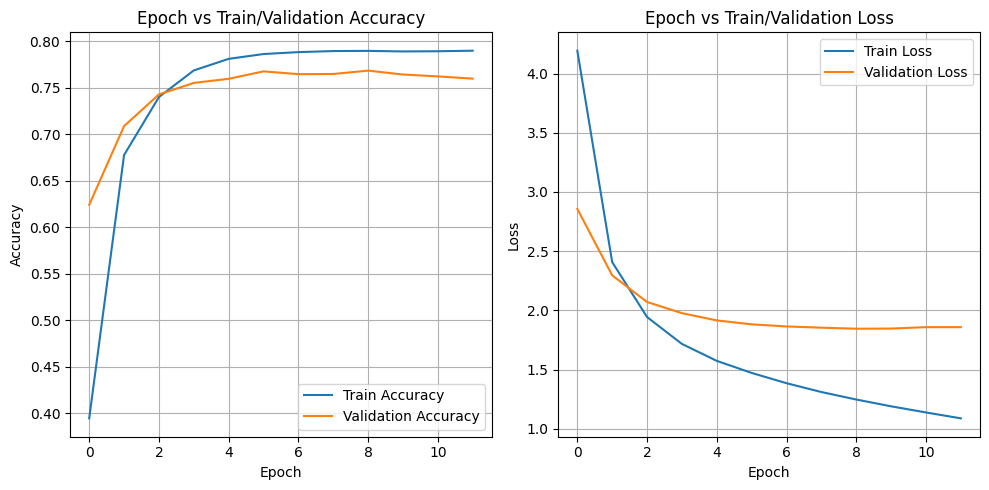

In [ ]:
LSTM_with_Word2Vec(embedding_dim=500,
                               num_layers=1,
                               units=100,
                               window=5)

Epoch 1/30
1250/1250 [==============================] - 11s 7ms/step - loss: 4.2224 - accuracy: 0.3925 - val_loss: 2.8668 - val_accuracy: 0.6149
Epoch 2/30
1250/1250 [==============================] - 9s 7ms/step - loss: 2.4207 - accuracy: 0.6729 - val_loss: 2.2790 - val_accuracy: 0.7017
Epoch 3/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.9410 - accuracy: 0.7381 - val_loss: 2.0559 - val_accuracy: 0.7335
Epoch 4/30
1250/1250 [==============================] - 8s 7ms/step - loss: 1.7063 - accuracy: 0.7687 - val_loss: 1.9393 - val_accuracy: 0.7524
Epoch 5/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.5618 - accuracy: 0.7813 - val_loss: 1.8774 - val_accuracy: 0.7650
Epoch 6/30
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4539 - accuracy: 0.7864 - val_loss: 1.8459 - val_accuracy: 0.7674
Epoch 7/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.3666 - accuracy: 0.7882 - val_loss: 1.8133 - val_accuracy

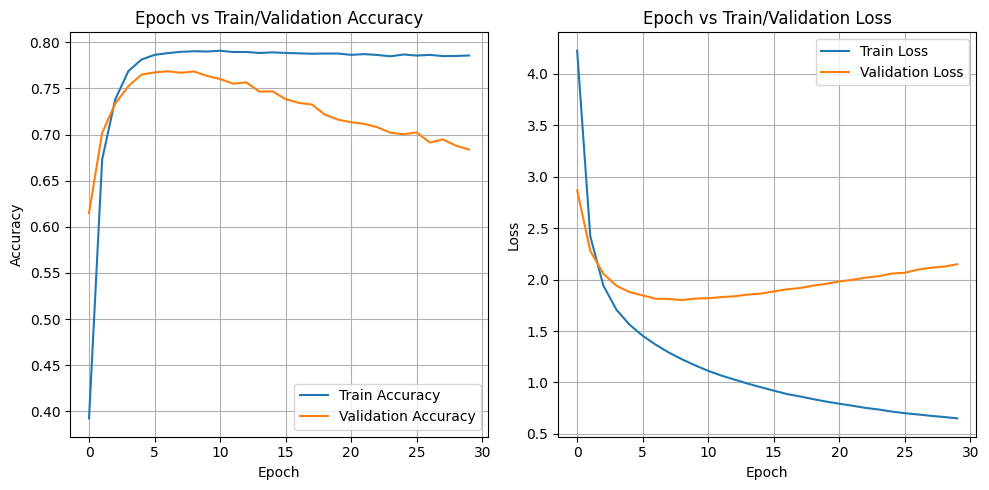

In [ ]:
mlflow.set_experiment('check_rel1')
LSTM_with_Word2Vec(embedding_dim=500,
                               num_layers=1,
                               units=100,
                               window=5)

300 , 1 , 5
Epoch 1/30
328/328 [==============================] - 21s 56ms/step - loss: 7.3131 - accuracy: 0.0591 - val_loss: 6.7599 - val_accuracy: 0.0640
Epoch 2/30
328/328 [==============================] - 17s 53ms/step - loss: 6.2887 - accuracy: 0.0779 - val_loss: 6.5942 - val_accuracy: 0.1021
Epoch 3/30
328/328 [==============================] - 17s 53ms/step - loss: 5.9210 - accuracy: 0.1190 - val_loss: 6.3400 - val_accuracy: 0.1387
Epoch 4/30
328/328 [==============================] - 18s 54ms/step - loss: 5.5092 - accuracy: 0.1623 - val_loss: 6.0667 - val_accuracy: 0.1860
Epoch 5/30
328/328 [==============================] - 18s 54ms/step - loss: 5.0924 - accuracy: 0.1961 - val_loss: 5.8867 - val_accuracy: 0.2149
Epoch 6/30
328/328 [==============================] - 18s 54ms/step - loss: 4.7123 - accuracy: 0.2208 - val_loss: 5.7081 - val_accuracy: 0.2416
Epoch 7/30
328/328 [==============================] - 18s 54ms/step - loss: 4.3678 - accuracy: 0.2375 - val_loss: 5.5982 - v

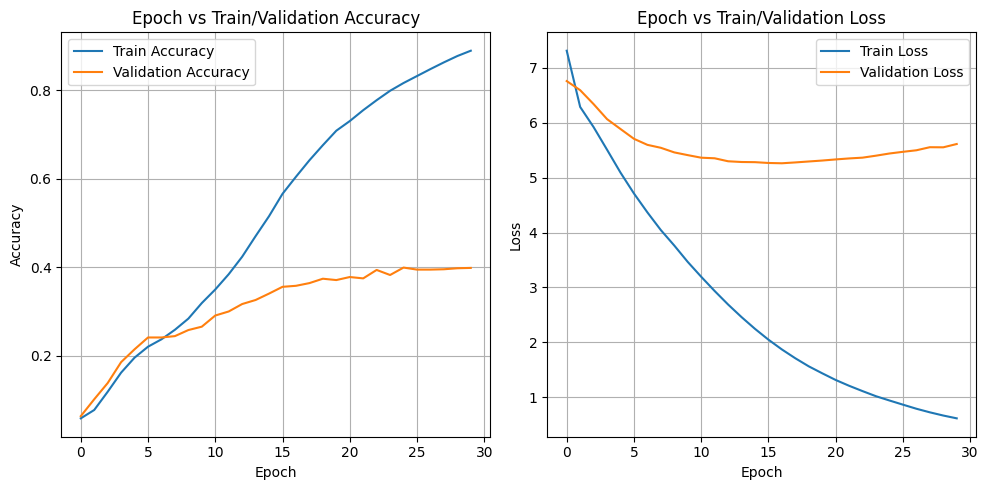

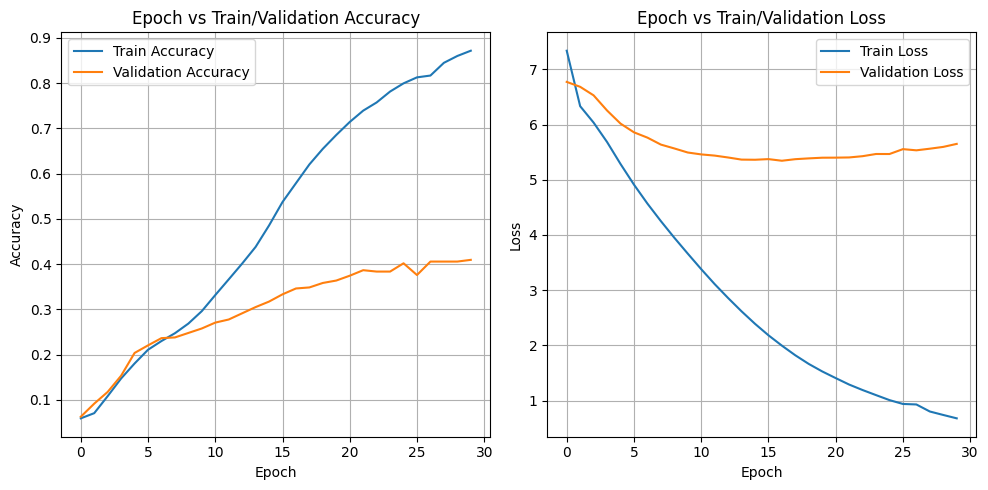

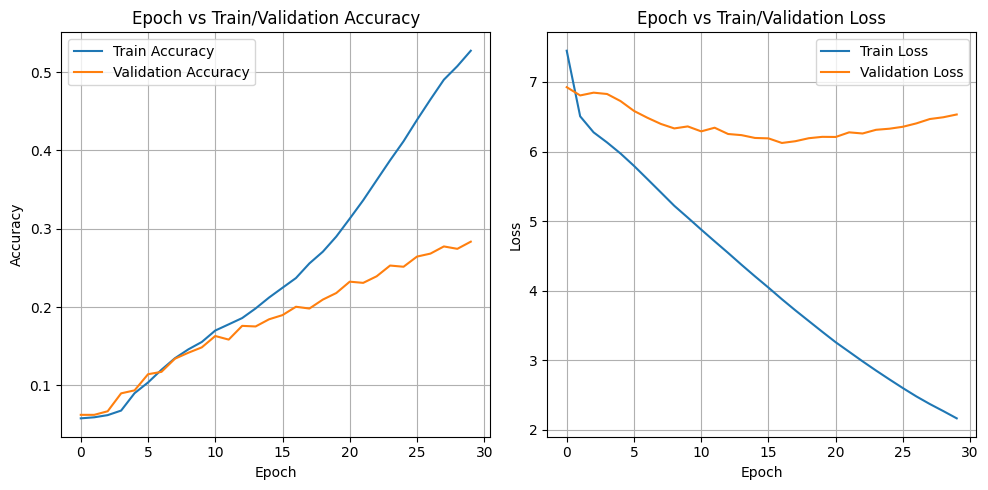

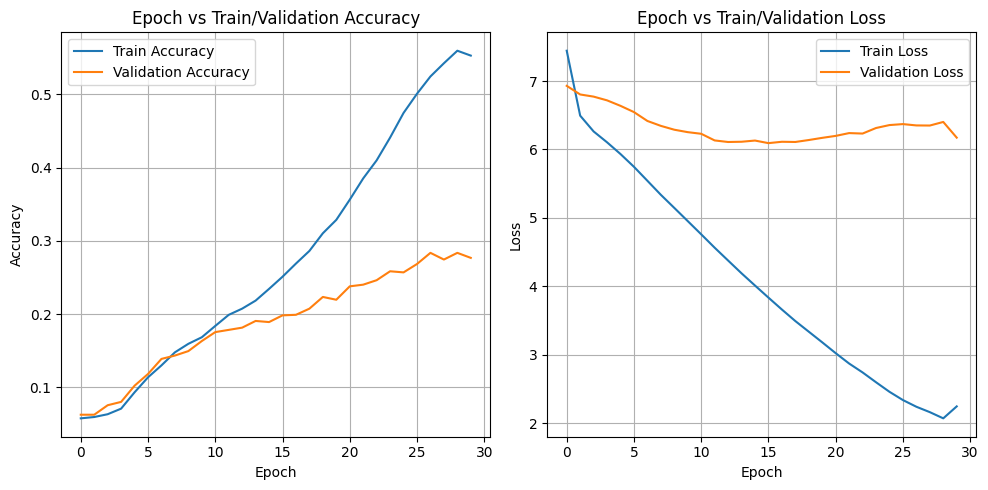

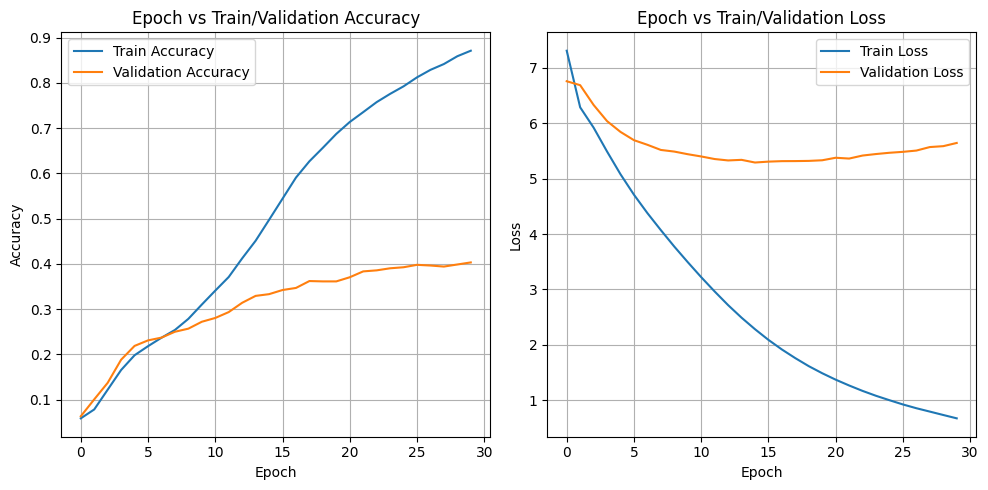

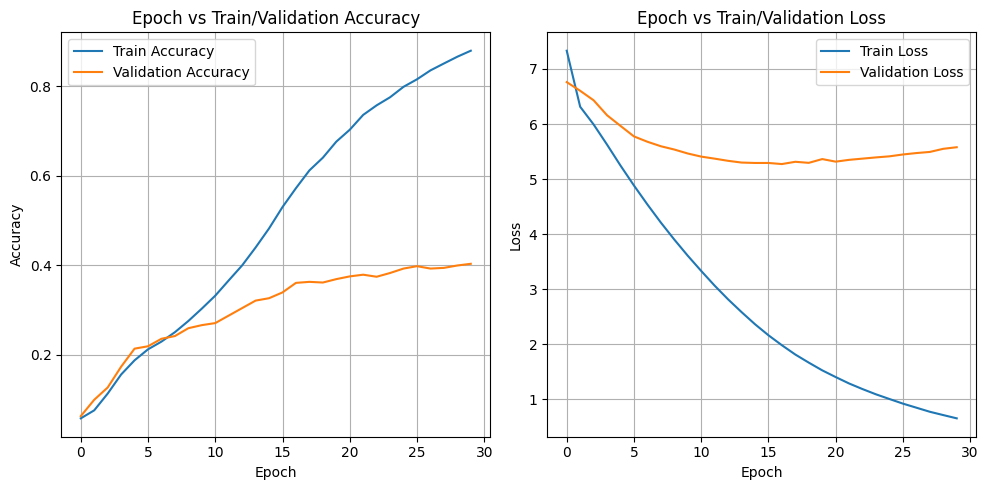

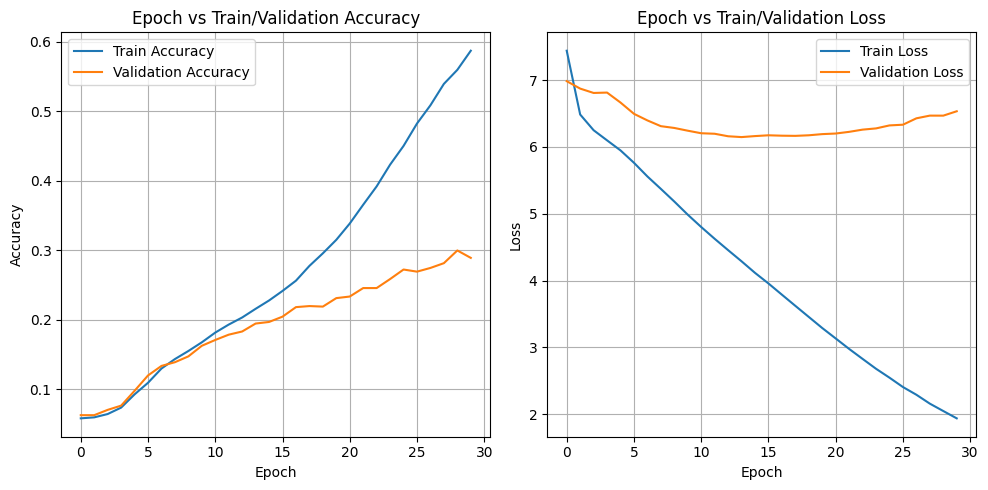

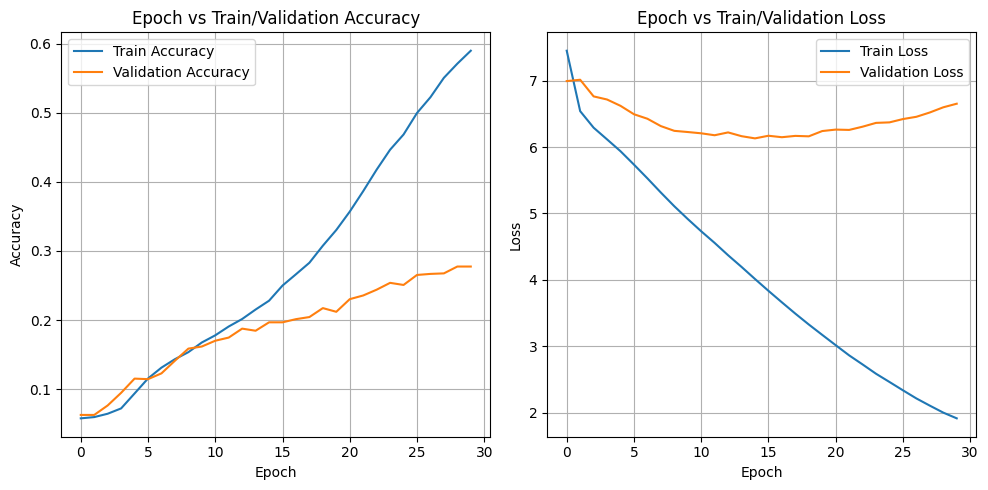

In [ ]:
# mlflow.create_experiment('LSTM_fullconv_word2vec')

mlflow.set_experiment('LSTM_fullconv_tword2vec')

for batch_size in [32]:
  for embedding_dim in [300, 500]:
    for num_layers in [1,3]:
      for units in [150]:
        for window in [5, 8]:
          for sg in [1]:
            # Start MLflow run
            with mlflow.start_run():
                print(embedding_dim,',',num_layers, ',',window)
                LSTM_with_Word2Vec(embedding_dim=embedding_dim,
                               num_layers=num_layers,
                               units=units,
                               window=window)





Epoch 1/30
762/762 [==============================] - 22s 23ms/step - loss: 7.4263 - accuracy: 0.0392 - val_loss: 7.2316 - val_accuracy: 0.0397
Epoch 2/30
762/762 [==============================] - 15s 19ms/step - loss: 6.5380 - accuracy: 0.0665 - val_loss: 6.7214 - val_accuracy: 0.0755
Epoch 3/30
762/762 [==============================] - 15s 20ms/step - loss: 5.8930 - accuracy: 0.1059 - val_loss: 6.3913 - val_accuracy: 0.1122
Epoch 4/30
762/762 [==============================] - 16s 21ms/step - loss: 5.3771 - accuracy: 0.1353 - val_loss: 6.1842 - val_accuracy: 0.1342
Epoch 5/30
762/762 [==============================] - 15s 20ms/step - loss: 4.9583 - accuracy: 0.1618 - val_loss: 6.0779 - val_accuracy: 0.1470
Epoch 6/30
762/762 [==============================] - 15s 20ms/step - loss: 4.5908 - accuracy: 0.1851 - val_loss: 5.9853 - val_accuracy: 0.1588
Epoch 7/30
762/762 [==============================] - 17s 22ms/step - loss: 4.2613 - accuracy: 0.2141 - val_loss: 5.9368 - val_accuracy:

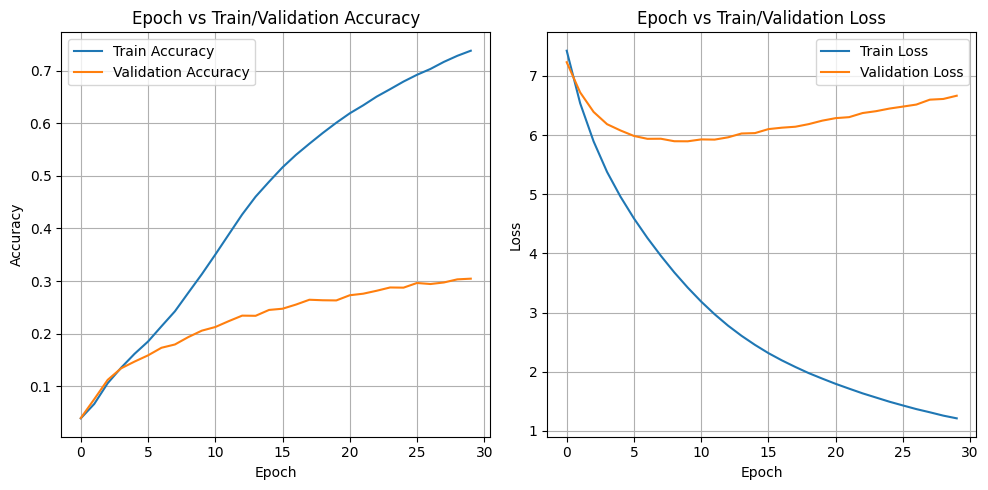

In [ ]:
LSTM_with_Word2Vec(embedding_dim=300) #Rel_Conv

Epoch 1/30
328/328 [==============================] - 20s 51ms/step - loss: 7.3797 - accuracy: 0.0573 - val_loss: 6.7910 - val_accuracy: 0.0625
Epoch 2/30
328/328 [==============================] - 15s 47ms/step - loss: 6.3691 - accuracy: 0.0606 - val_loss: 6.6885 - val_accuracy: 0.0724
Epoch 3/30
328/328 [==============================] - 16s 48ms/step - loss: 6.1375 - accuracy: 0.0862 - val_loss: 6.6153 - val_accuracy: 0.1075
Epoch 4/30
328/328 [==============================] - 16s 49ms/step - loss: 5.8712 - accuracy: 0.1193 - val_loss: 6.3715 - val_accuracy: 0.1341
Epoch 5/30
328/328 [==============================] - 16s 49ms/step - loss: 5.5571 - accuracy: 0.1573 - val_loss: 6.1789 - val_accuracy: 0.1730
Epoch 6/30
328/328 [==============================] - 16s 49ms/step - loss: 5.2533 - accuracy: 0.1819 - val_loss: 6.0551 - val_accuracy: 0.2005
Epoch 7/30
328/328 [==============================] - 16s 48ms/step - loss: 4.9900 - accuracy: 0.2017 - val_loss: 5.8879 - val_accuracy:

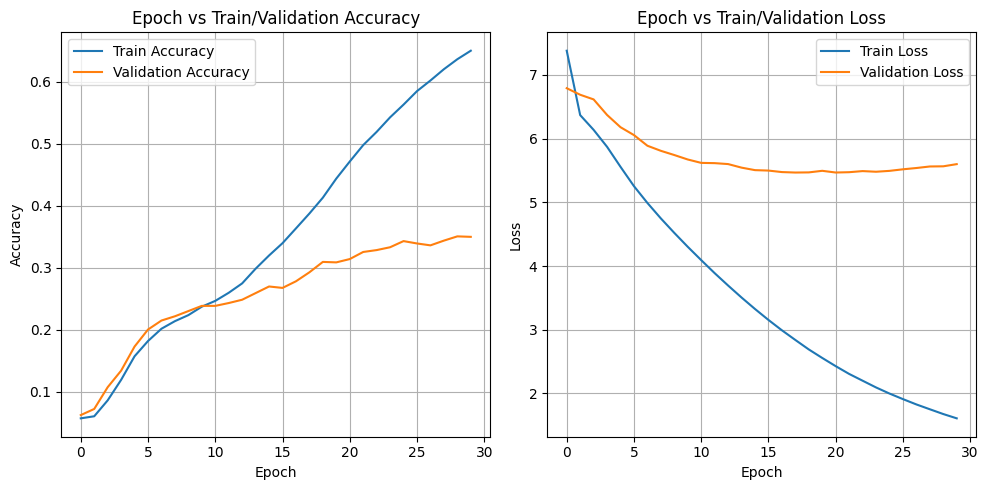

In [ ]:
LSTM_with_Word2Vec(embedding_dim=300)       #Full Conversation

##Glove Embeddings

In [ ]:
embeddings_index = dict()
f = open('/content/glove.6B.50d.txt',mode='rt',encoding='utf-8')
for line in f:
    values = line.split()
    words = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[words] = coefs
f.close()

print('Loaded word vectors',len(embeddings_index)) #Loaded word vectors 400000


Loaded word vectors 400000


In [ ]:
def LSTM_model_glove(num_layers = 1, units = 100, embedding_dim = 50, optimizer = 'adam', batch_size = 32, epochs = 30, embeddings_index=embeddings_index):


  # print(length, num_layers, units, embedding_dim, '/n')

  #Logging all parameters
  mlflow.log_param('batch_size',batch_size)
  mlflow.log_param('layers',num_layers)
  mlflow.log_param('units',units)
  mlflow.log_param('embedding_dim',embedding_dim)
  mlflow.log_param('epochs',epochs)
  mlflow.log_param('optimizer',optimizer)
  # mlflow.log_param('length',length)

  # processed_conversations = preprocess(length, conversations)

  # Data Preprocessing
  tokenizer = Tokenizer(oov_token='<oov>')
  tokenizer.fit_on_texts(processed_conversations)
  vocab_size = len(tokenizer.word_index) + 1

  sequences = tokenizer.texts_to_sequences(processed_conversations)
  max_sequence_len = max([len(seq) for seq in sequences])
  padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

  X = padded_sequences[:, :-1]
  y = padded_sequences[:, -1]

  # Convert target data to one-hot encoding
  y = np_utils.to_categorical(y, num_classes=vocab_size)

  # Splitting the data into train, validation, and test sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

  print("Training set shape:", X_train.shape, y_train.shape)
  print("Validation set shape:", X_val.shape, y_val.shape)
  print("Test set shape:", X_test.shape, y_test.shape)


  # Prepare embedding matrix
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word,i in tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if(embedding_vector is not None):
          embedding_matrix[i] = embedding_vector



  if num_layers == 1:
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],input_length=max_sequence_len - 1 , trainable=False),
    tf.keras.layers.LSTM(units),
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.Dense(vocab_size, activation='softmax')])

  else:
    model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],input_length=max_sequence_len - 1 , trainable=False),
            tf.keras.layers.LSTM(units, return_sequences=True),
        ])
    for i in range(num_layers-2):
      model.add(tf.keras.layers.LSTM(units, return_sequences=True))
    model.add(tf.keras.layers.LSTM(units))
    model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Define early stopping to prevent overfitting
  early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

  # Train the model
  with tf.device('/GPU:0'):  # Specify GPU device
    history = model.fit(X_train, y_train, batch_size= batch_size , epochs=epochs, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

  # Log train and validation loss and accuracy for each epoch
  for epoch in range(len(history.history['loss'])):
      mlflow.log_metric("train_loss", history.history['loss'][epoch], epoch)
      mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], epoch)
      mlflow.log_metric("val_loss", history.history['val_loss'][epoch], epoch)
      mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], epoch)



  # Plot epoch vs train accuracy and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Epoch vs Train/Validation Accuracy')
  plt.legend()
  plt.grid(True)

  # Plot epoch vs train loss and validation loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Epoch vs Train/Validation Loss')
  plt.legend()
  plt.grid(True)

  # Adjust layout and save the plot as an image file
  plt.tight_layout()
  plt.savefig("epoch_vs_metrics.png")

  # Log the plot to MLflow
  mlflow.log_artifact("epoch_vs_metrics.png")

  # Evaluate the model on the test set
  test_loss, test_accuracy, perplexity, top_k_accuracy = evaluate_model(model, X_test, y_test)


  print("Test Loss:", test_loss)
  print("Test Accuracy:", test_accuracy)
  print("Perplexity:", perplexity)
  print("Top-5 Accuracy:", top_k_accuracy)

  # Log test metrics
  mlflow.log_metric("test_loss", test_loss)
  mlflow.log_metric("test_accuracy", test_accuracy)
  mlflow.log_metric("perplexity", perplexity)
  mlflow.log_metric("top_5_accuracy", top_k_accuracy)


Layers: 1 Units: 100 Batch: 32
Training set shape: (39996, 4) (39996, 1722)
Validation set shape: (4999, 4) (4999, 1722)
Test set shape: (5000, 4) (5000, 1722)
Epoch 1/30
1250/1250 [==============================] - 13s 8ms/step - loss: 4.9909 - accuracy: 0.2196 - val_loss: 3.9645 - val_accuracy: 0.4345
Epoch 2/30
1250/1250 [==============================] - 7s 5ms/step - loss: 3.3516 - accuracy: 0.5188 - val_loss: 3.1944 - val_accuracy: 0.5835
Epoch 3/30
1250/1250 [==============================] - 10s 8ms/step - loss: 2.5972 - accuracy: 0.6335 - val_loss: 2.8216 - val_accuracy: 0.6663
Epoch 4/30
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1472 - accuracy: 0.6971 - val_loss: 2.6471 - val_accuracy: 0.7041
Epoch 5/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.8862 - accuracy: 0.7354 - val_loss: 2.6063 - val_accuracy: 0.7269
Epoch 6/30
1250/1250 [==============================] - 9s 7ms/step - loss: 1.7283 - accuracy: 0.7530 - val_loss: 2.58

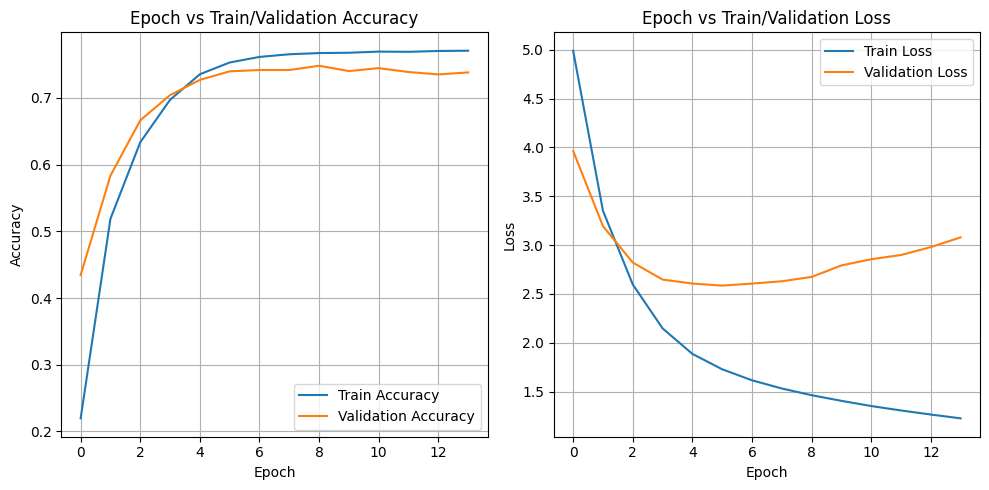

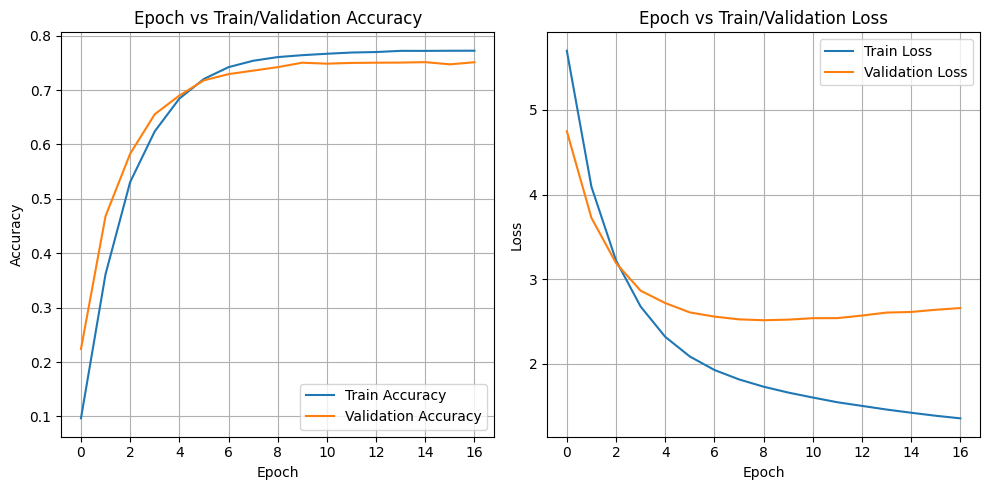

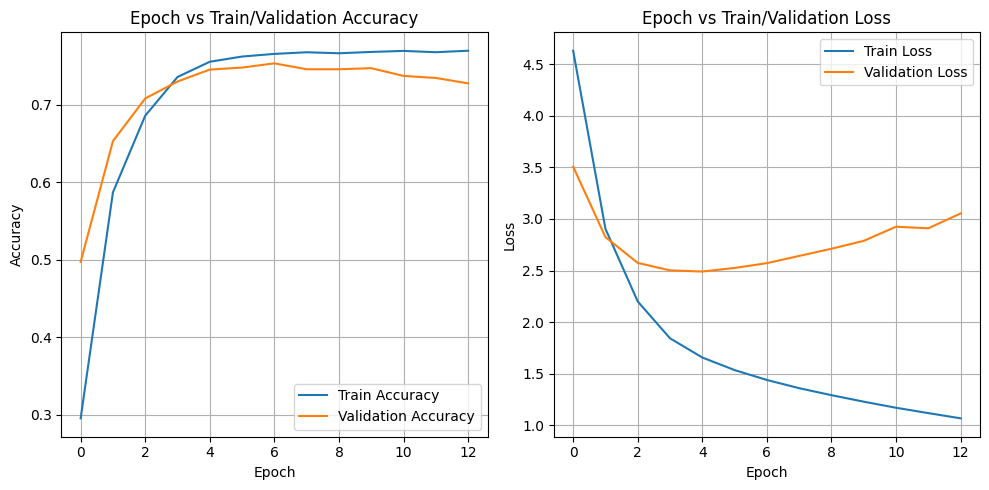

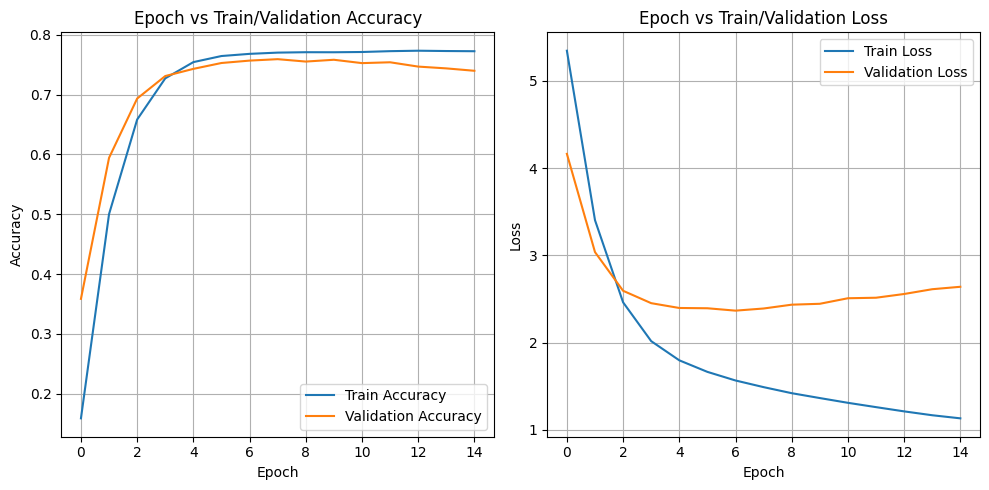

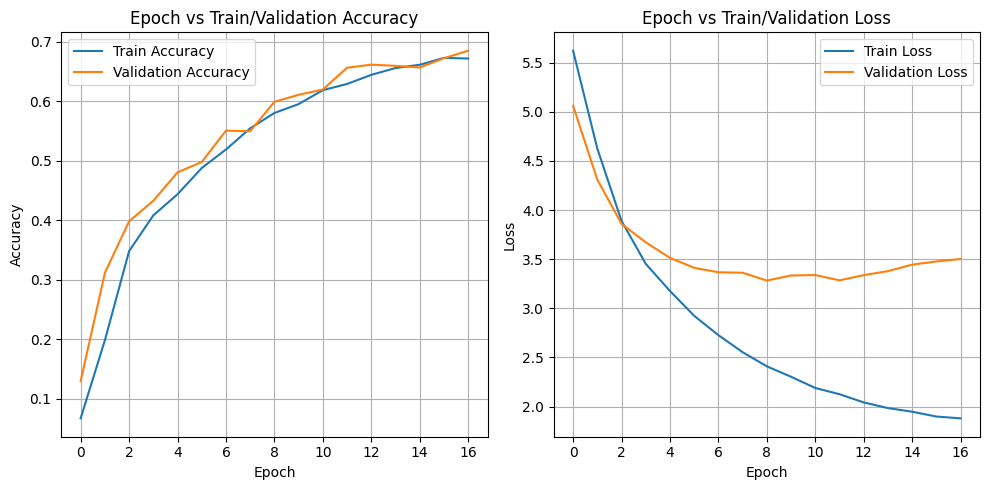

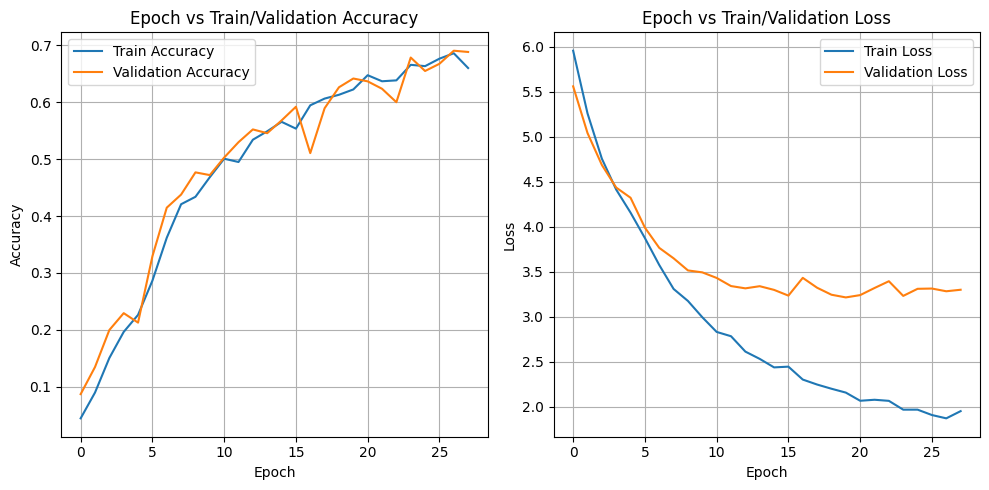

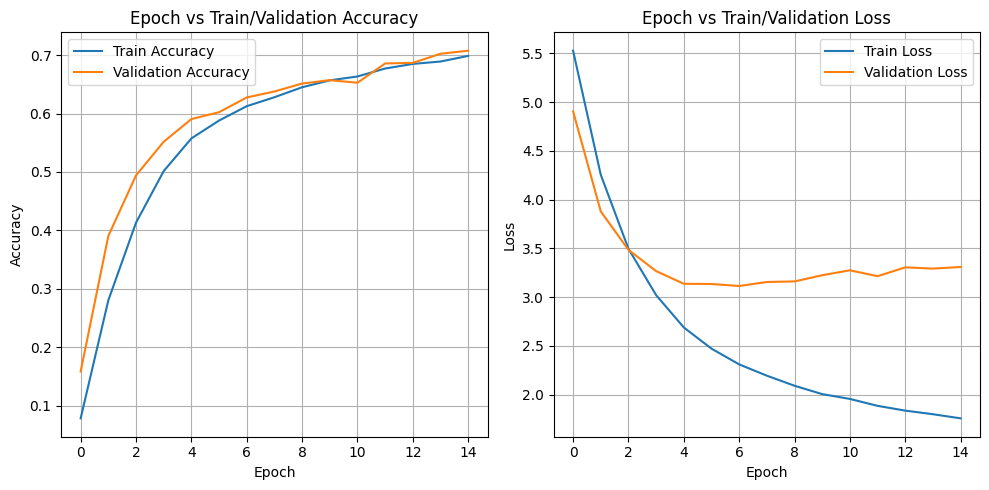

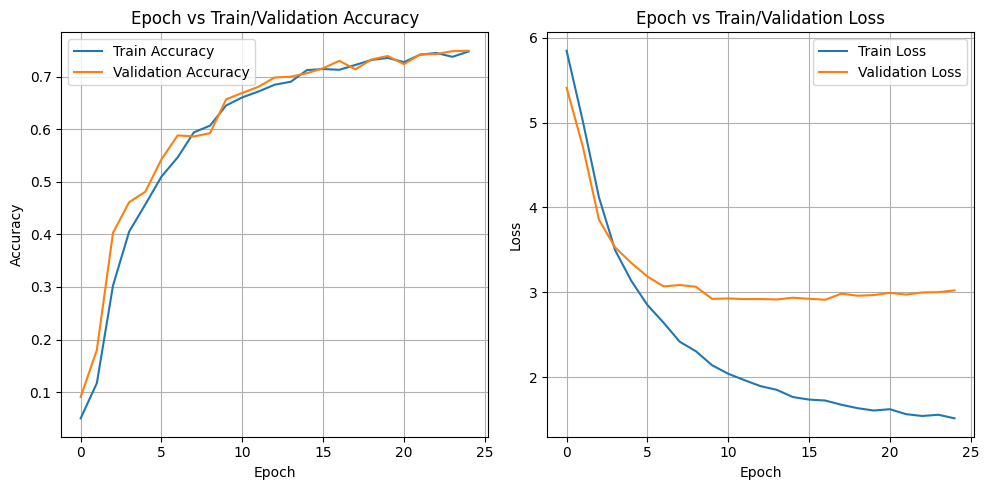

In [ ]:
#MLFlow Experiments

# mlflow.create_experiment('Rel_glove')

mlflow.set_experiment('Rel_glove')

for num_layers in [1,5]:
  for units in [100, 200]:
    for batch_size in [32, 128]:
      with mlflow.start_run():
        print('Layers:',num_layers, 'Units:',units, 'Batch:', batch_size)
        LSTM_model_glove(num_layers = num_layers, units = units, batch_size = batch_size)

####ML FLow Experiments

In [ ]:
#MLFlow Experiments

mlflow.create_experiment('fullconv_glove_utter')

mlflow.set_experiment('fullconv_glove_utter')

for num_layers in [1,5]:
  for units in [100, 200]:
    for batch_size in [32, 128]:
      with mlflow.start_run():
        print('Layers:',num_layers, 'Units:',units, 'Batch:', batch_size)
        LSTM_model_glove(num_layers = num_layers, units = units, batch_size = batch_size)

5 1 100 200 /n
Training set shape: (24375, 151) (24375, 13139)
Validation set shape: (3047, 151) (3047, 13139)
Test set shape: (3047, 151) (3047, 13139)
Epoch 1/30
762/762 [==============================] - 17s 18ms/step - loss: 7.3686 - accuracy: 0.0361 - val_loss: 7.1563 - val_accuracy: 0.0371
Epoch 2/30
762/762 [==============================] - 13s 18ms/step - loss: 6.5462 - accuracy: 0.0575 - val_loss: 6.8906 - val_accuracy: 0.0627
Epoch 3/30
762/762 [==============================] - 14s 18ms/step - loss: 6.0066 - accuracy: 0.0795 - val_loss: 6.7358 - val_accuracy: 0.0798
Epoch 4/30
762/762 [==============================] - 14s 18ms/step - loss: 5.5549 - accuracy: 0.1047 - val_loss: 6.6518 - val_accuracy: 0.1014
Epoch 5/30
762/762 [==============================] - 14s 19ms/step - loss: 5.1490 - accuracy: 0.1240 - val_loss: 6.6214 - val_accuracy: 0.1099
Epoch 6/30
762/762 [==============================] - 13s 17ms/step - loss: 4.7694 - accuracy: 0.1456 - val_loss: 6.7216 - val_

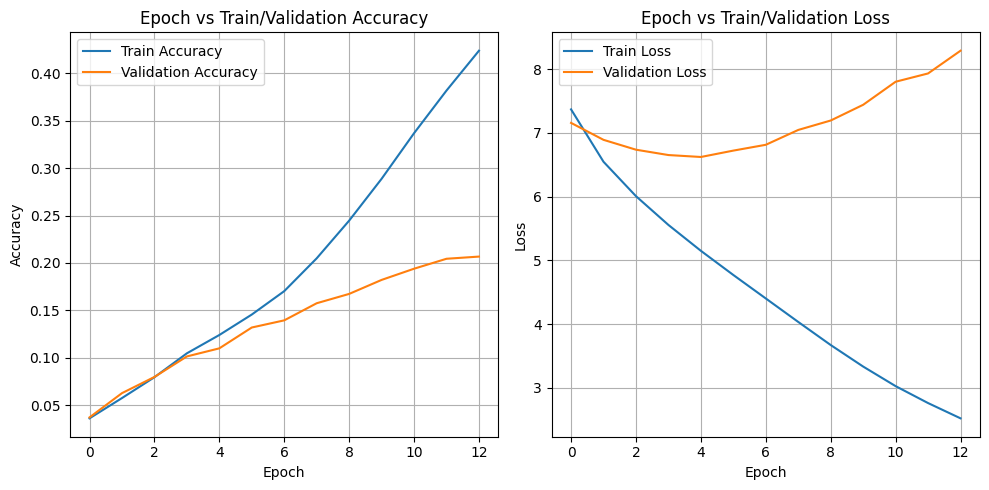

In [ ]:
# mlflow.create_experiment('check_rel_glove_utter')

mlflow.set_experiment('check_rel_glove_utter')
LSTM_model_glove(5,1,100,200)

###Each Utterance

In [ ]:
sequences=[]
for conv in conversations:
  for item in conv.split('__eou__'):
    sequences.append(item)
sequences

['Bob , what are you thinking about ? ',
 " I'm looking forward to going to America . ",
 ' When do you go ? ',
 ' Next week . ',
 '\n',
 'What do you say to eating out , Maggie ? ',
 " Yeah , why not ? We haven't been out for dinner for quite a long time . A new French restaurant has just opened in our neighborhood . We can go there . ",
 ' Do we need to book a table in advance ? ',
 " No need for that . It's not usually busy on weekdays . ",
 ' What time shall we go ? ',
 " Why not now ? I'm hungry . ",
 '\n',
 'What a wonderful party ! I had a good time . How about you ? ',
 ' I enjoyed myself , too . ',
 ' Shall I give you a ride home ? ',
 " Yes , if it's not too much of a trouble . ",
 " It's no trouble at all because your house is on the way to my place . ",
 " That's great . Let's go ! ",
 '\n',
 'How did you know ? ',
 ' It was a kind of sixth sense . ',
 ' Does it happen often ? ',
 ' No . ',
 '\n',
 "What's your favorite magazine ? ",
 " Off hand , I'd say the Reader's Diges

In [ ]:
# Define translation table to remove punctuation
remove_punctuation_table = str.maketrans('', '', string.punctuation)

# Remove punctuation from processed_conversations
processed_conversations = [conv.lower().translate(remove_punctuation_table).strip().replace(' ’ ','’') for conv in sequences]


In [ ]:
processed_conversations[:10]

['bob  what are you thinking about',
 'im looking forward to going to america',
 'when do you go',
 'next week',
 '',
 'what do you say to eating out  maggie',
 'yeah  why not  we havent been out for dinner for quite a long time  a new french restaurant has just opened in our neighborhood  we can go there',
 'do we need to book a table in advance',
 'no need for that  its not usually busy on weekdays',
 'what time shall we go']

In [ ]:
len(processed_conversations)

36649

In [ ]:
processed_conversations = [conv for conv in processed_conversations if len(conv.split())>2]

In [ ]:
# Data Preprocessing
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(processed_conversations)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

sequences = tokenizer.texts_to_sequences(processed_conversations)


max_sequence_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

X = padded_sequences[:, :-1]
y = padded_sequences[:, -1]

# Splitting the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

5 1 200 200 /n
50000
Training set shape: (39996, 4) (39996, 4385)
Validation set shape: (4999, 4) (4999, 4385)
Test set shape: (5000, 4) (5000, 4385)
Epoch 1/30
1250/1250 [==============================] - 12s 8ms/step - loss: 6.1840 - accuracy: 0.0688 - val_loss: 5.8882 - val_accuracy: 0.0894
Epoch 2/30
1250/1250 [==============================] - 9s 7ms/step - loss: 5.5083 - accuracy: 0.1103 - val_loss: 5.7302 - val_accuracy: 0.1122
Epoch 3/30
1250/1250 [==============================] - 10s 8ms/step - loss: 5.0593 - accuracy: 0.1314 - val_loss: 5.6600 - val_accuracy: 0.1194
Epoch 4/30
1250/1250 [==============================] - 9s 7ms/step - loss: 4.7019 - accuracy: 0.1481 - val_loss: 5.7659 - val_accuracy: 0.1324
Epoch 5/30
1250/1250 [==============================] - 10s 8ms/step - loss: 4.3623 - accuracy: 0.1679 - val_loss: 5.9203 - val_accuracy: 0.1368
Epoch 6/30
1250/1250 [==============================] - 9s 7ms/step - loss: 4.0129 - accuracy: 0.1915 - val_loss: 6.1461 - val_

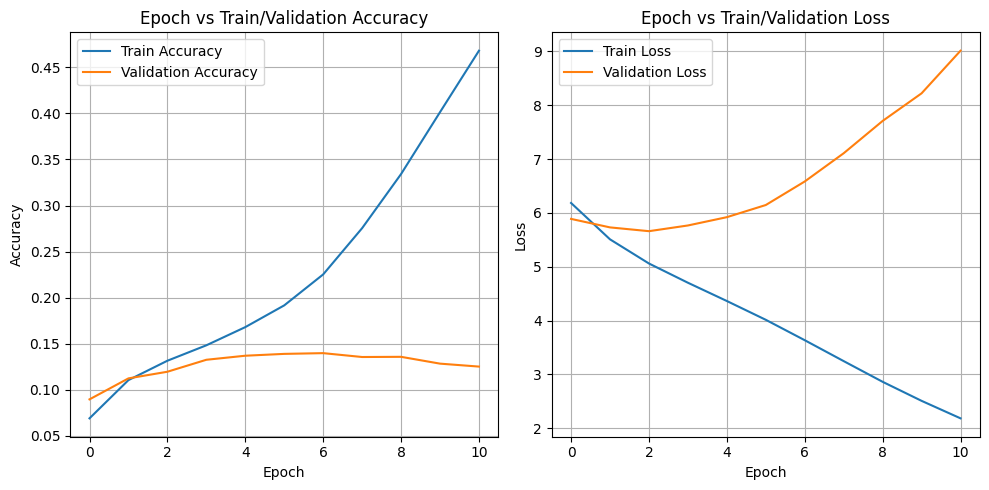

In [ ]:
# mlflow.create_experiment('check_rel_glove')

mlflow.set_experiment('check_rel_glove')
LSTM_model_glove(5,1,200,200)

###Full Conversation

In [ ]:
# Read the text file dataset
with open("/content/drive/MyDrive/NLP_Project/ijcnlp_dailydialog/dialogues_text.txt", "r", encoding="utf-8") as file:
    conversations = file.readlines()

In [ ]:
# Preprocess the dataset
processed_conversations = [conv.strip().rsplit(' ',1)[0].rstrip(string.punctuation+' ').lower().replace(' ’ ','’').replace('__eou__','') for conv in conversations]
# processed_conversations = [conv.replace(string.punctuation,'') for conv in processed_conversations]
# processed_conversations[2]
# Define translation table to remove punctuation
remove_punctuation_table = str.maketrans('', '', string.punctuation.replace('\'',''))

# Remove punctuation from processed_conversations
processed_conversations_no_punct = [conv.translate(remove_punctuation_table) for conv in processed_conversations]

# Print processed_conversations without punctuation
# processed_conversations_no_punct[2]

processed_conversations = processed_conversations_no_punct
processed_conversations[2]

'are things still going badly with your houseguest   getting worse  now he’s eating me out of house and home  i’ve tried talking to him but it all goes in one ear and out the other  he makes himself at home  which is fine  but what really gets me is that yesterday he walked into the living room in the raw and i had company over  that was the last straw   leo  i really think you’re beating around the bush with this guy  i know he used to be your best friend in college  but i really think it’s time to lay down the law   you’re right  everything is probably going to come to a head tonight  i’ll keep you informed'

#Parallel Plot for ml_flow runs

<ipython-input-14-67a2c0ab04ad>:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f'{title}.png')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


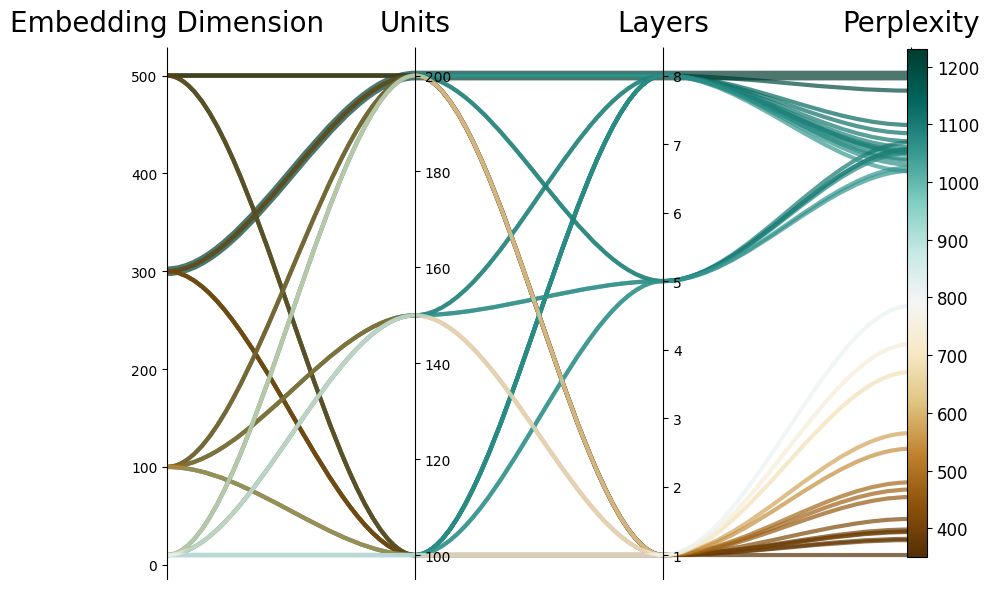

Embedding Dimension  Units  Layers   Perplexity
0                   500    200       8  1202.512994
1                   500    100       8  1139.503273
2                   500    200       1   377.265815
3                   500    100       1   470.047139
4                   300    200       8  1230.260451
5                   300    100       8  1109.567330
6                   300    200       1   392.060434
7                   300    100       1   573.867421
8                   500    200       8  1124.441849
9                   500    100       8  1077.190406
10                  500    200       1   349.829772
11                  500    100       1   379.514876
12                  300    200       8  1098.537700
13                  300    100       8  1088.767570
14                  300    200       1   393.141177
15                  300    100       1   416.101643
16                  300    100       1   396.694024
17                  100    200       8  1074.265583
18                  100    150       8  1091.795909
19                  100    100       8  1085.211401
20                  100    200       5  1095.414397
21                  100    150       5  1107.840162
22                  100    100       5  1089.007451
23                  100    200       1   456.301895
24                  100    150       1   483.336999
25                  100    100       1   545.090306
26                   10    200       8  1054.568498
27                   10    150       8  1090.354775
28                   10    100       8  1066.764385
29                   10    200       5  1095.050913
30                   10    150       5  1061.564221
31                   10    100       5  1055.349724
32                   10    200       1   686.130504
33                   10    150       1   737.483231
34                   10    100       1   807.795744

In [14]:
df = pd.read_csv('/content/runs-7.csv')
df.columns

df = df[['embedding_dim', 'units', 'layers','perplexity']].dropna()
df.sort_values('perplexity')

title = ' '

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm

def parallel_plot(table4: pd.DataFrame, acc_col: str, title: str, vars_names, my_vars_names):
    """
    acc_col: col name of the accuracy column, eg., "acc_1", "acc_2"
    """

    df_plot = table4[['embedding_dim', 'units', 'layers', 'perplexity']]
    df_plot.columns = ["Embedding Dimension", "Units", "Layers", "Perplexity"]
    df_plot = df_plot.reset_index(drop=True)

    order_map = {}
    for c in ["Embedding Dimension", "Units", "Layers", "Perplexity"]:
        tmp_ = list(df_plot[c].unique())
        try:
            tmp_2 = sorted(list(map(float, tmp_)))
            tmp_2 = sorted(list(map(float, tmp_)))
            n_unique = list(map(str, tmp_2))
        except:
            n_unique = sorted(tmp_)
        tmp = {x:i for i,x in enumerate(n_unique)}
        order_map[c] = tmp.copy()

    parallel_plot_matlab(df_plot, ["Embedding Dimension", "Units", "Layers", "Perplexity"], order_map, title)
    return df_plot

def parallel_plot_matlab(df_plot, my_vars_names, order_map, title):
    # Convert to numeric matrix
    ym = []
    dics_vars = []
    for v, var in enumerate(my_vars_names):
        if df_plot[var].dtype.kind not in ["i", "u", "f"]:
            dic_var = order_map[var]
            dics_vars += [dic_var]
            ym += [[dic_var[i] for i in df_plot[var].tolist()]]
        else:
            ym += [df_plot[var].tolist()]
    ym = np.array(ym).T

    # Normalize 'Accuracy'
    metric = df_plot['Perplexity'].values
    metric_normalized = (metric - metric.min()) / (metric.max() - metric.min())

    # Padding
    ymins = ym.min(axis=0)
    ymaxs = ym.max(axis=0)
    dys = ymaxs - ymins
    ymins -= dys * 0.05
    ymaxs += dys * 0.05

    # Reverse some axes for better visual
    axes_to_reverse = [0, 1, 2, 3]
    for a in axes_to_reverse:
        pass

    # Adjust to the main axis
    zs = np.zeros_like(ym)
    zs[:, 0] = ym[:, 0]
    zs[:, 1:] = (ym[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

    # Plot
    fig, host_ax = plt.subplots(figsize=(10, 6), tight_layout=True)

    # Create a continuous colormap (e.g., from light blue to dark blue)
    cmap_continuous = plt.cm.BrBG

    # Make the axes
    axes = [host_ax] + [host_ax.twinx() for i in range(ym.shape[1] - 1)]
    dic_count = 0
    for i, ax in enumerate(axes):
        ax.set_ylim(bottom=ymins[i], top=ymaxs[i])
        ax.spines.top.set_visible(False)
        ax.spines.bottom.set_visible(False)
        ax.ticklabel_format(style='plain')
        if ax != host_ax:
            ax.spines.left.set_visible(False)
            ax.yaxis.set_ticks_position("right")
            ax.spines.right.set_position(("axes", i / (ym.shape[1] - 1)))
        if df_plot.iloc[:, i].dtype.kind not in ["i", "u", "f"]:
            dic_var_i = dics_vars[dic_count]
            ax.set_yticks(range(len(dic_var_i)))
            ax.set_yticklabels([key_val for key_val in dics_vars[dic_count].keys()], fontsize=20,  verticalalignment='bottom')
            dic_count += 1
    host_ax.set_xlim(left=0, right=ym.shape[1] - 1)
    host_ax.set_xticks(range(ym.shape[1]))
    host_ax.set_xticklabels(my_vars_names, fontsize=20)
    host_ax.tick_params(axis="x", which="major", pad=7)

    # Make the curves
    host_ax.spines.right.set_visible(False)
    host_ax.xaxis.tick_top()
    for j in range(ym.shape[0]):
        verts = list(zip([x for x in np.linspace(0, len(ym) - 1, len(ym) * 3 - 2, endpoint=True)],
                         np.repeat(zs[j, :], 3)[1:-1]))
        codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        color = cmap_continuous(metric_normalized[j])  # Color based on normalized metric
        if metric_normalized[j] == 1:
            patch = patches.PathPatch(path, facecolor="none", lw=7, alpha=0.7, edgecolor=color)
        else:
            patch = patches.PathPatch(path, facecolor="none", lw=3, alpha=0.7, edgecolor=color)
        host_ax.add_patch(patch)

    # Identify the position of the Accuracy axis
    # This is the last axis in your plot
    accuracy_axis_index = len(my_vars_names) - 1
    orig_pos = axes[accuracy_axis_index].get_position()

    # Create a ScalarMappable object for the color bar
    sm = cm.ScalarMappable(cmap=cmap_continuous, norm=plt.Normalize(vmin=metric.min(), vmax=metric.max()))
    sm.set_array([])  # You can set an empty array because the color bar doesn't need actual data

    # Hide the original Accuracy axis
    axes[accuracy_axis_index].set_visible(False)

    # Calculate the position for the color bar
    cbar_width = 0.02
    cbar_pos = [orig_pos.x0 + orig_pos.width + cbar_width * 1.1-0.01, orig_pos.y0 / 1.8, cbar_width, orig_pos.height * 1.1]

    # Create a new axes for the color bar at the calculated position and add it to the figure
    cbar_ax = fig.add_axes(cbar_pos)
    cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.ax.tick_params(labelsize=12)  # Adjust font size of color bar ticks
    # plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()  # Display the plot

# Example usage:
# table4 = pd.read_csv('your_data.csv')
# parallel_plot(df, 'perplexity', 'title', ['batch_size', 'embedding_dim', 'units', 'layers'], ["Batch","Embedding Dimension", "Units", "Layers"])
parallel_plot(df, 'perplexity', 'title', ['embedding_dim','units', 'layers'], ["Embedding Dimension", "Units", "Layers"])